In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython import display
import functions as f 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline
%config InlineBackend.figure_format='retina'



In [2]:
df = pd.read_pickle('data/rent_cleaned.pkl')

In [3]:
# Define Plot Color
blue = sns.color_palette()[0]
# Plot Style
plt.style.use('seaborn')
# Define Matplotlib Params
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.titlesize'] = 'xx-large' 
mpl.rcParams['axes.titlesize'] = 'large' 

mpl.rcParams['axes.titley'] = 1.03 

### Part 1: How to Break into the Field

In [4]:
mean_rent_sqm = df.groupby('year').rent_sqm.mean().reset_index(name='rent_sqm_mean')



Text(0, 0.5, 'Rent per $m^2$ [ € ]')

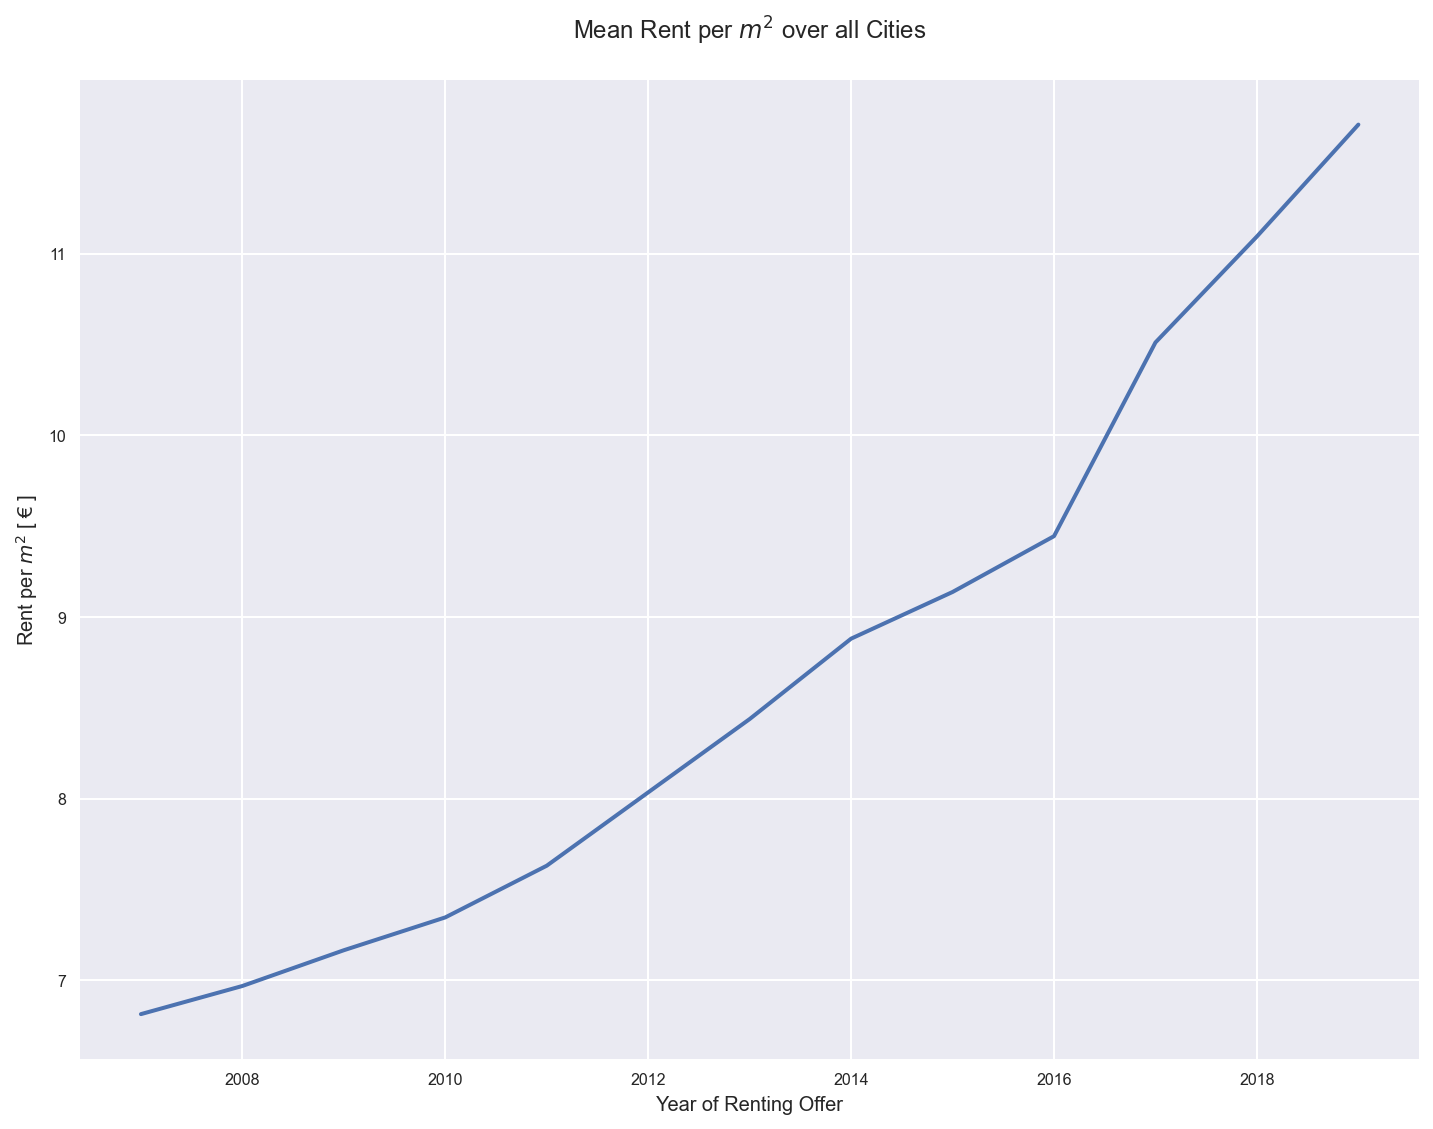

In [5]:

sns.lineplot(data=mean_rent_sqm, x='year', y='rent_sqm_mean', legend=True)
plt.title('Mean Rent per $m^2$ over all Cities')
plt.xlabel('Year of Renting Offer')
plt.ylabel('Rent per $m^2$ [ € ]')

In [6]:
# Calculate percentage change  from 2008 to 2019
mean_rent_sqm.iloc[12, 1] / mean_rent_sqm.iloc[0, 1] * 100 - 100

71.87191354070143

In [7]:
# Overview of anbieter value_counts
df.anbieter.value_counts(dropna=False)

NaN                   2501339
Wohnungswirtschaft      53038
Makler                  52691
Privatanbieter          38160
Bauträger                3426
Gewerbeanbieter          2245
Finanzsektor              655
unbekannt                 252
Hausbau                    77
Umzug                       2
Name: anbieter, dtype: int64

### Part 2: Clustering

In [8]:
# Define the columns for the clustering
columns = ['mietekalt', 'wohnflaeche',
       'aufzug', 'balkon',
       'einbaukueche', 'ev_wwenthalten', 'foerderung', 'gaestewc', 'garten',
       'heizkosten_in_wm_enthalten', 'keller', 'parkplatz', 'rollstuhlgerecht',
       'ausstattung', 'energieausweistyp',
       'haustier_erlaubt', 'heizungsart', 'kategorie_Wohnung', 'objektzustand',
       'anbieter', 'rent_sqm',
       'Wärmezufuhr', 'Erdgas leicht', 'Erdgas schwer',
       'keine Information', 'Windenergie', 'Pellets', 'Solarenergie', 'Koks',
       'kombinierte erneuerbare Energie', 'Erdwärme', 'Bioenergie',
       'Wasserenergie', 'Nahwärme', 'Fernwärme', 'Holzschnitzel', 'Öl',
       'kombinierte regenerative Energie', 'Kohle',
       'kombinierte Fossilkraftstoffe', 'Gas', 'Holz', 'Heizdampf-Fernwärme',
       'thermische Umweltenergie', 'Flüssiggas', 'kombinierte Bio Energie',
       'Elektro']

In [9]:
# Define a clustering dataframe with specific columns
clustering_df = df[columns]

In [10]:
# Define cleaned input vector X with one hot encoded columns 
X, _ = f.clean_data(clustering_df)

#### Principal Component Analysis 

In [11]:
from sklearn.preprocessing import Normalizer

In [12]:
# normalize the data
normalizer = Normalizer()
normalized_values = normalizer.fit_transform(X)

In [13]:
%%time
from sklearn.decomposition import PCA

# One less as original feature number
N_COMPONENTS = clustering_df.shape[1] - 1


pca = PCA(n_components=N_COMPONENTS)
pca.fit(normalized_values)

print('explained_variance_ratio_ vector:', pca.explained_variance_ratio_)
print('explained_variance_ratio_ sum:', pca.explained_variance_ratio_.sum())



explained_variance_ratio_ vector: [9.68278801e-01 1.85564686e-02 2.27019464e-03 1.37248825e-03
 1.01199913e-03 7.45879467e-04 7.28307712e-04 6.40762545e-04
 5.68988029e-04 5.15833117e-04 4.71447284e-04 4.03917499e-04
 3.79443113e-04 3.65957913e-04 2.90513442e-04 2.86590093e-04
 2.76179786e-04 2.67995267e-04 2.56931596e-04 2.53959286e-04
 2.16206940e-04 2.15103345e-04 1.87873326e-04 1.80750800e-04
 1.56552631e-04 1.35079825e-04 1.12768669e-04 9.47020722e-05
 9.12955393e-05 8.32515031e-05 6.99115917e-05 5.13973648e-05
 4.66097738e-05 3.98819956e-05 3.70392831e-05 3.60474689e-05
 3.01267458e-05 2.75928631e-05 2.65417402e-05 2.35629563e-05
 2.10924381e-05 1.98777237e-05 1.90706915e-05 1.85472865e-05
 1.78887444e-05 1.35793434e-05]
explained_variance_ratio_ sum: 0.999915010742311
CPU times: user 1min 26s, sys: 42.6 s, total: 2min 9s
Wall time: 41.5 s


In [14]:
s = pd.DataFrame(pca.singular_values_)
v = pd.DataFrame(pca.components_)

In [15]:
f.explained_variance(s, 1)

0.968361101567274

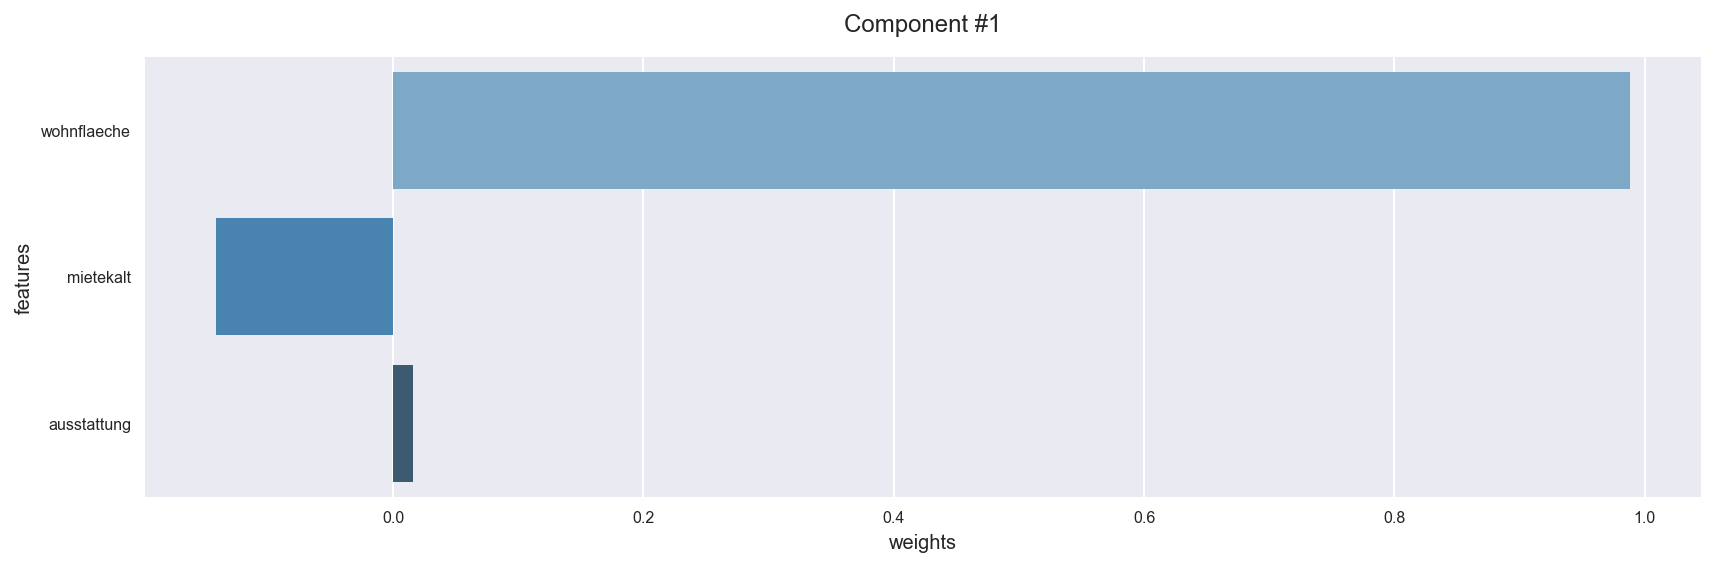

In [16]:
figure = plt.figure(figsize=(12,4.0))

for i in range(1):
    plt.subplot(1,1,i+1)
    f.display_components(v, clustering_df.columns, i, n_weights=3)
    plt.title('Component #{}'.format(i+1))
figure.tight_layout()




## Setup K-Means
Create K-Means analysis to find groups in customers based only on customer features

### Create input data based on PCA analysis
Use the `pca.transform()` function to create input data for the K-Means analysis.

In [17]:
%%time
# Create input data from PCA Analysis
pca_transformed = pca.fit_transform(normalized_values)

pca_transformed = pd.DataFrame(pca_transformed)
pca_transformed = pca_transformed.iloc[:,:1]
PCA_list=['c_1']
pca_transformed.columns=PCA_list

pca_transformed.head()



CPU times: user 1min 24s, sys: 37.9 s, total: 2min 2s
Wall time: 36.8 s


,c_1
0,0.031864
1,0.024591
2,0.009932
3,0.009932
4,0.041829


In [18]:
%%time
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


# Do a loop over different k's to find the optimum
inertias = []
distortions = []
for i in range(1,7):
    kmeans = KMeans(n_clusters=i).fit(pca_transformed)
    cluster_centers = kmeans.cluster_centers_
    inertias.append(kmeans.inertia_)
    
    distortions.append(sum(np.min(cdist(pca_transformed, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / pca_transformed.shape[0])
                                        
    inertias.append(kmeans.inertia_)
    

CPU times: user 4min 34s, sys: 56.3 s, total: 5min 30s
Wall time: 50.4 s


In [19]:
distortions

[0.038414334863363375,
 0.02096931488353747,
 0.014828273692402917,
 0.01163484814449888,
 0.009608591159038166,
 0.008073817084692814]

<AxesSubplot:>

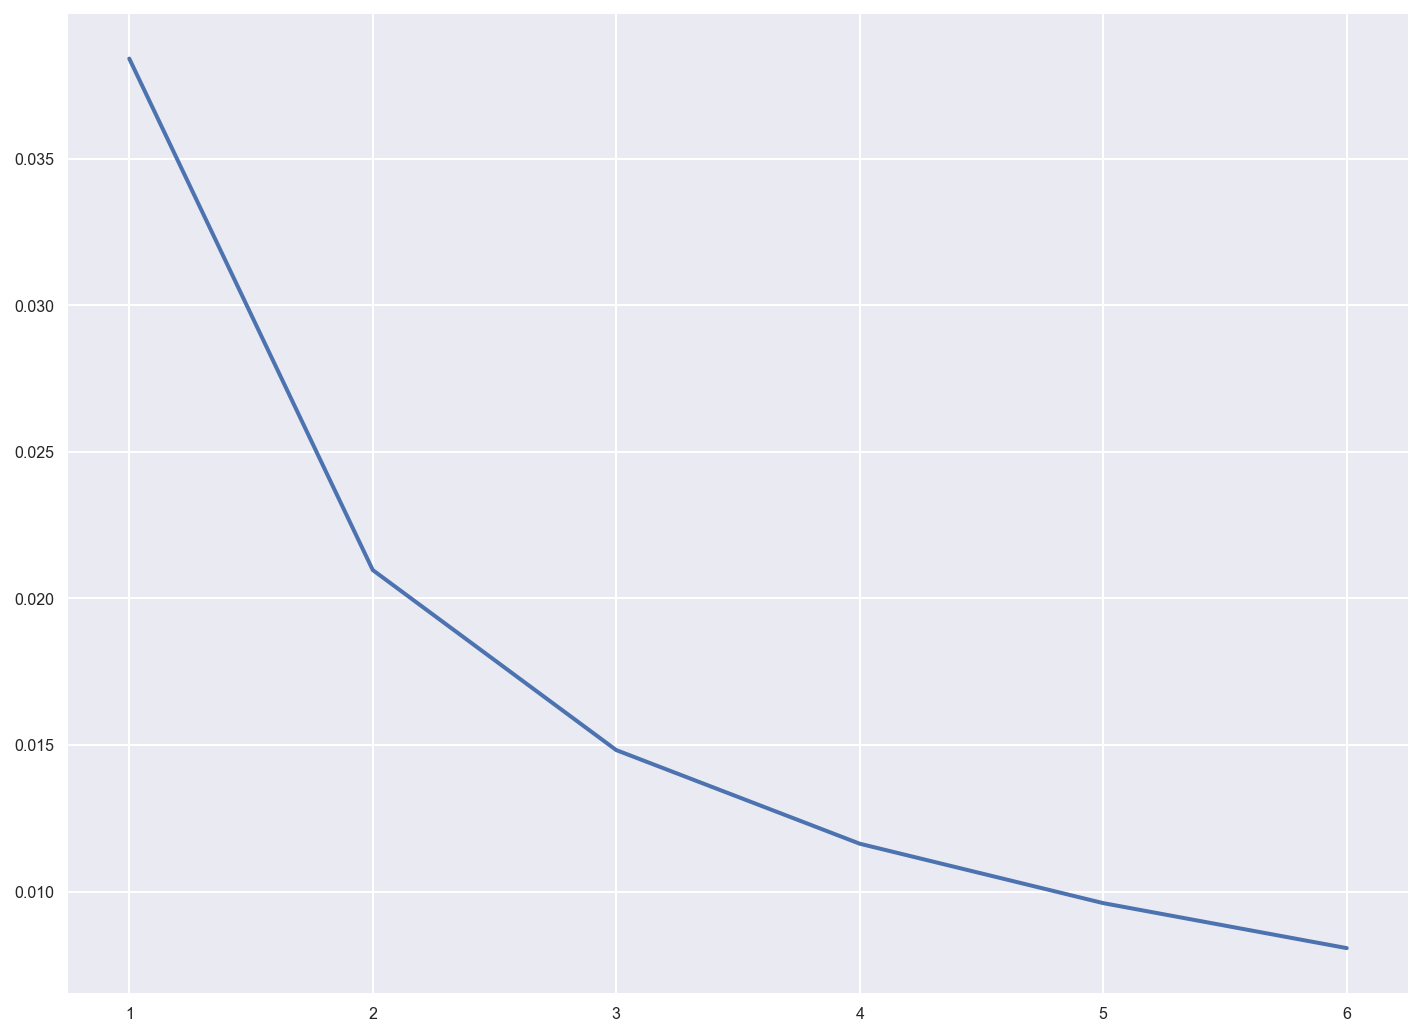

In [20]:
sns.lineplot(x=range(1,7), y=distortions)

In [21]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(pca_transformed)
labels = kmeans.labels_

CPU times: user 38.1 s, sys: 6.58 s, total: 44.7 s
Wall time: 5.95 s


In [22]:
cluster_df = pd.DataFrame(kmeans.cluster_centers_, columns=pca_transformed.columns)


Text(0.5, 1.03, 'Attribute Value by Centroid')

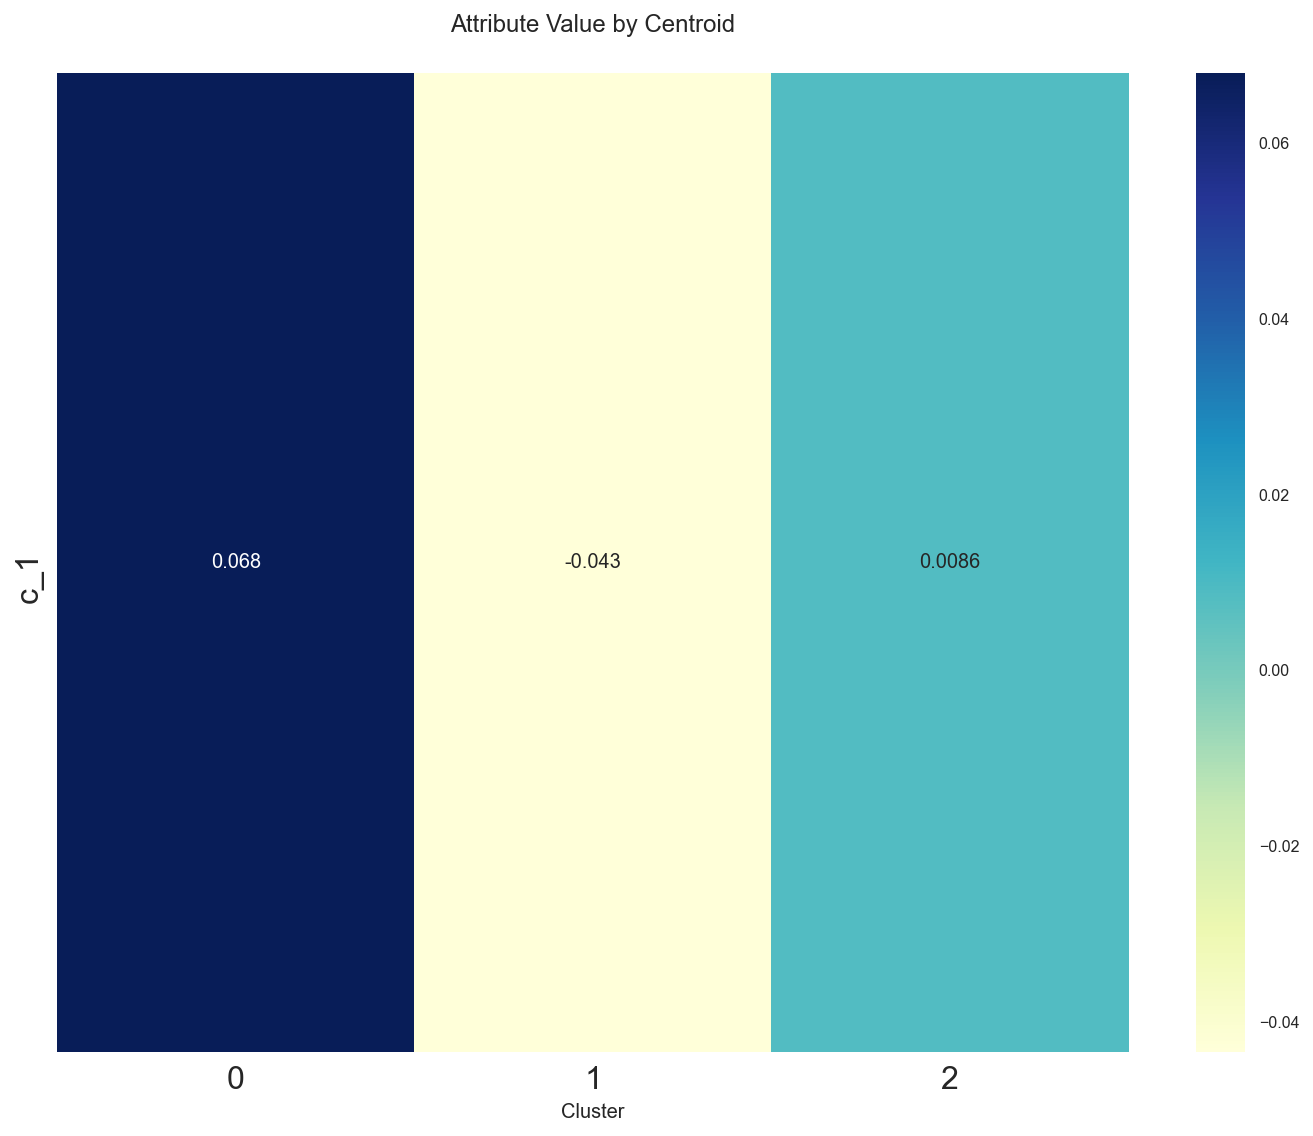

In [23]:
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_df.T, cmap = 'YlGnBu', annot=True)
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")



#### Analyse Clusters


In [24]:
# Add the labels to dataframe
df.loc[:, 'label'] = labels

In [33]:
# map the labels
# Attention label_mapping needs update
label_mapping = {1:'high priced', 2:'medium priced', 0:'low priced'}


df.label = df.label.map(label_mapping)



In [34]:
df.ausstattung.fillna('Unbekannt', inplace=True)

In [37]:
ausstattung = df.groupby(['label']).ausstattung.value_counts(dropna=False, normalize=True).reset_index(name='ausstattung_count')
ausstattung.head()

,label,ausstattung,ausstattung_count
0,high priced,Unbekannt,0.451033
1,high priced,Gehoben,0.325782
2,high priced,Normal,0.179147
3,high priced,Luxus,0.039271
4,high priced,Einfach,0.004767


Text(0, 0.5, 'Count')

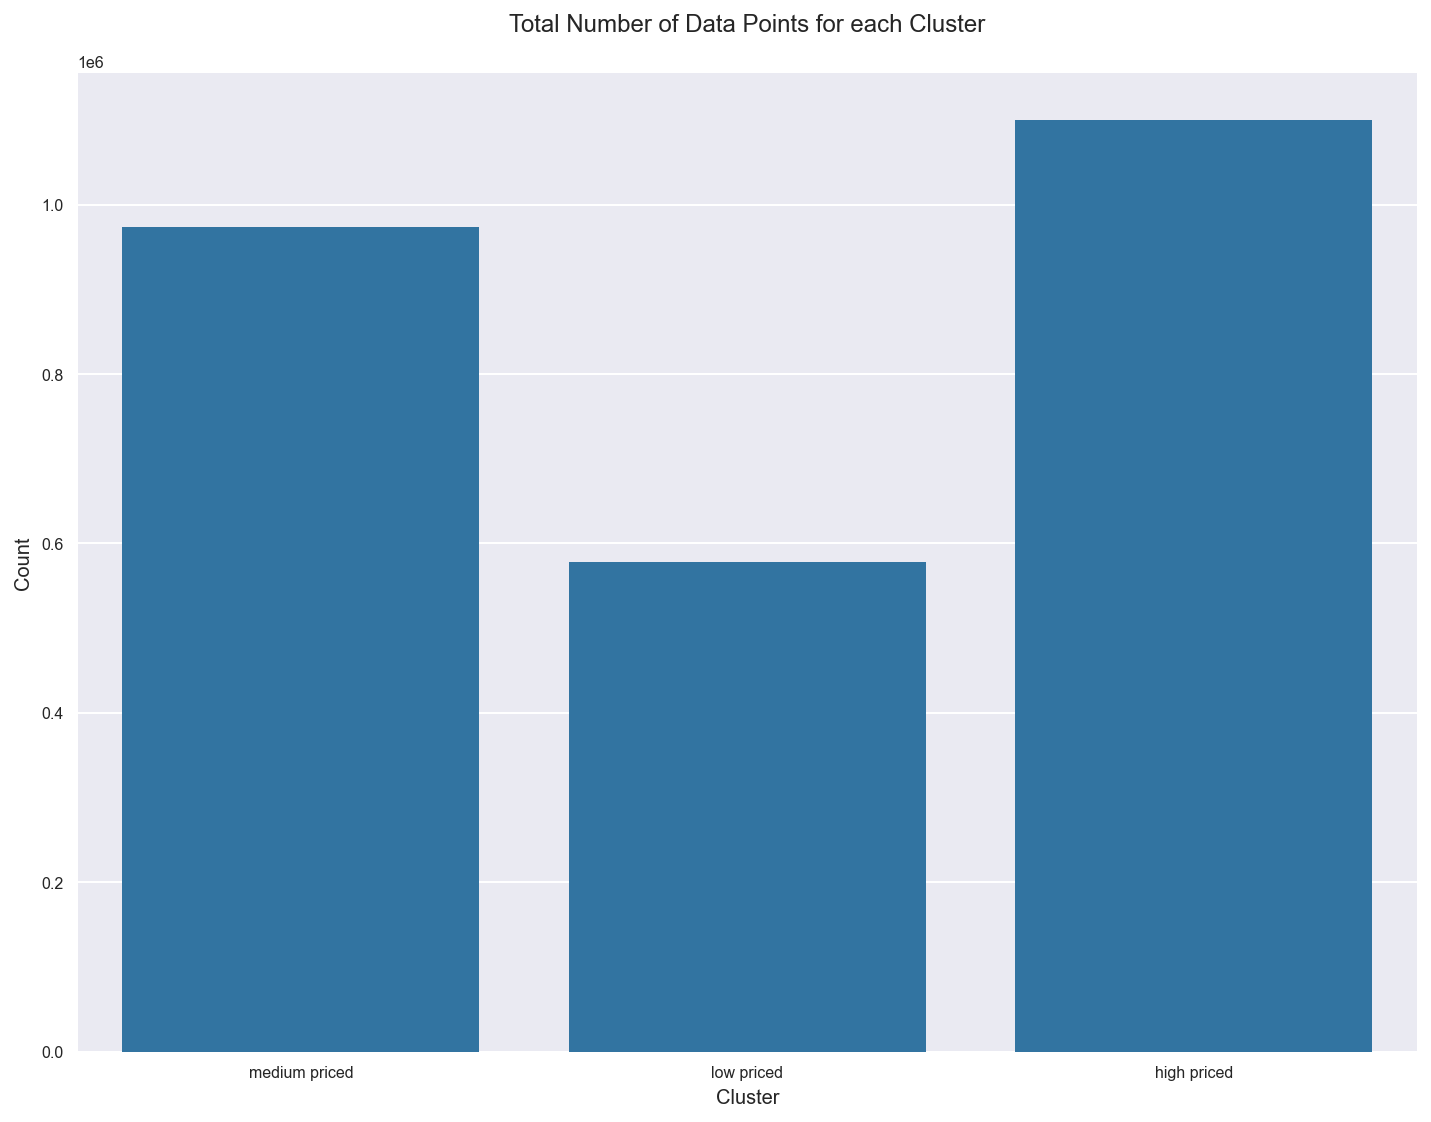

In [36]:
sns.countplot(data=df, x='label', color=blue)

plt.title('Total Number of Data Points for each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

Text(0.5, 1.03, 'Mean Rent for defined clusters')

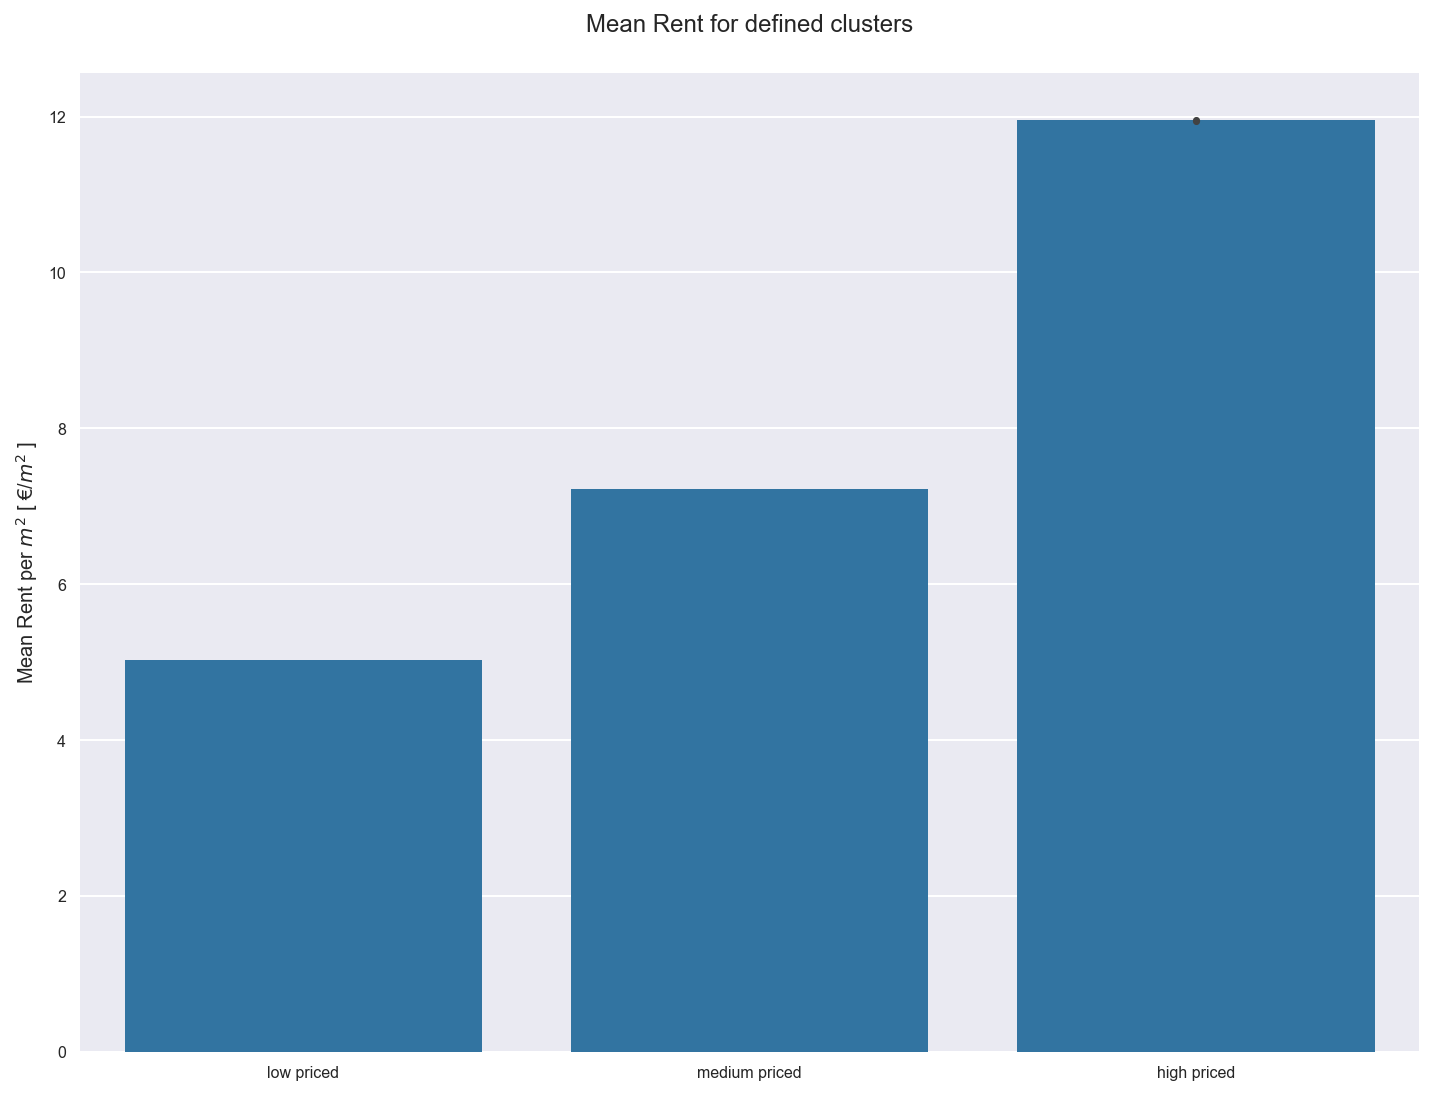

In [44]:
# Create Plot with mean rents for cluster
# , order=label_order, color=blue
sns.barplot(data=df, x='label', y='rent_sqm', order=label_order, color=blue);
plt.xlabel(None)
plt.ylabel('Mean Rent per $m^2$ [ €/$m^2$ ]')

plt.title('Mean Rent for defined clusters')

Text(0.5, 1.03, 'Mean Rent for defined clusters')

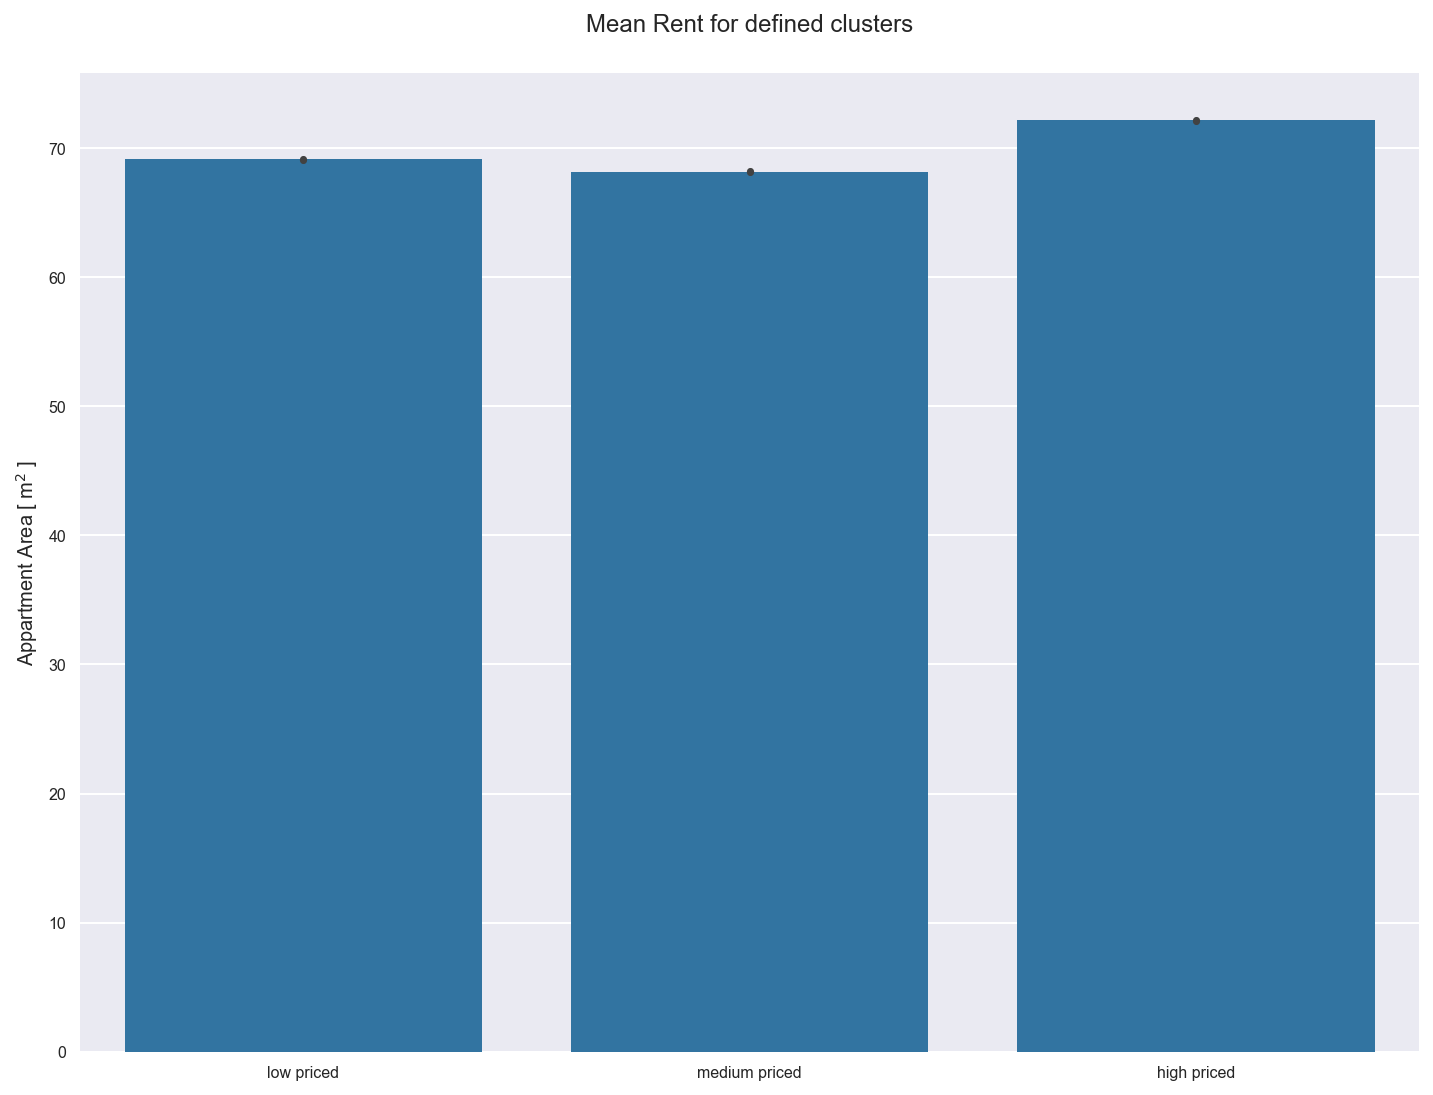

In [59]:
# , order=label_order
sns.barplot(data=df, x='label', y='wohnflaeche', color=blue, order=label_order);
plt.xlabel(None)
plt.ylabel('Appartment Area [ m$^2$ ]')
plt.title('Mean Rent for defined clusters')



In [39]:
# Define some orders for plot order
label_order = ['low priced', 'medium priced', 'high priced']
ausstattung_order = ['Einfach', 'Normal', 'Gehoben', 'Luxus', 'Unbekannt']

 

Text(0, 0.5, 'Ausstattung Count Ratio')

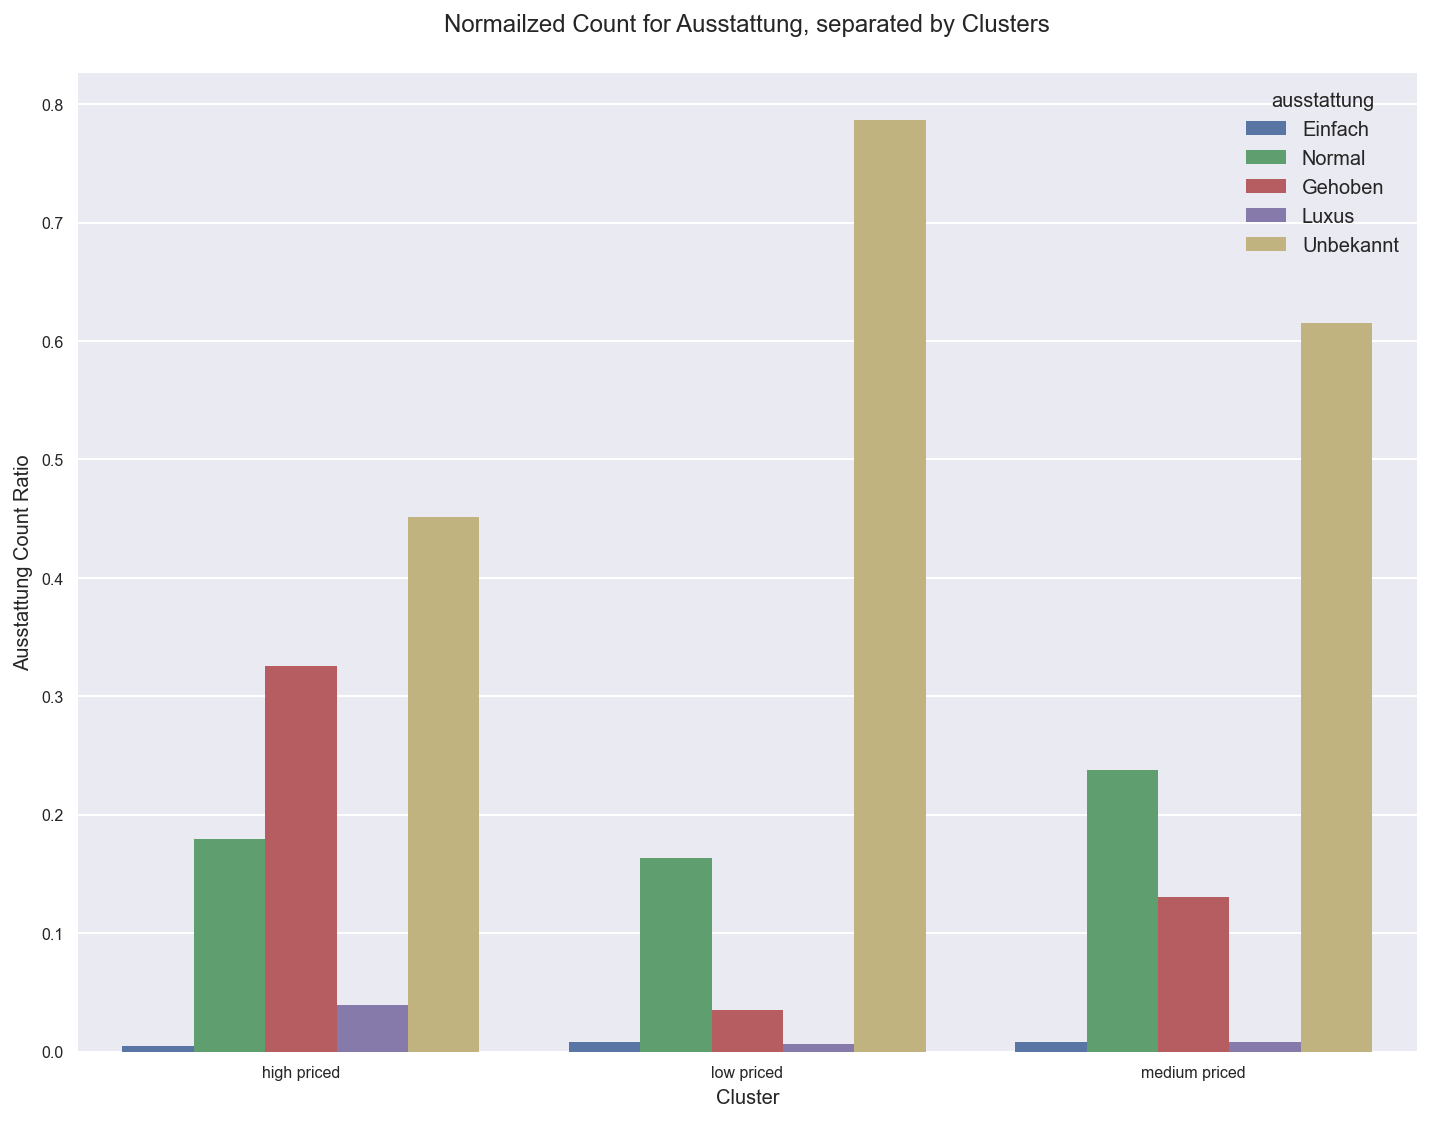

In [40]:
sns.barplot(data=ausstattung, x='label', y='ausstattung_count', hue='ausstattung', hue_order=ausstattung_order)
plt.title('Normailzed Count for Ausstattung, separated by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Ausstattung Count Ratio')

Text(0, 0.5, 'Frequency')

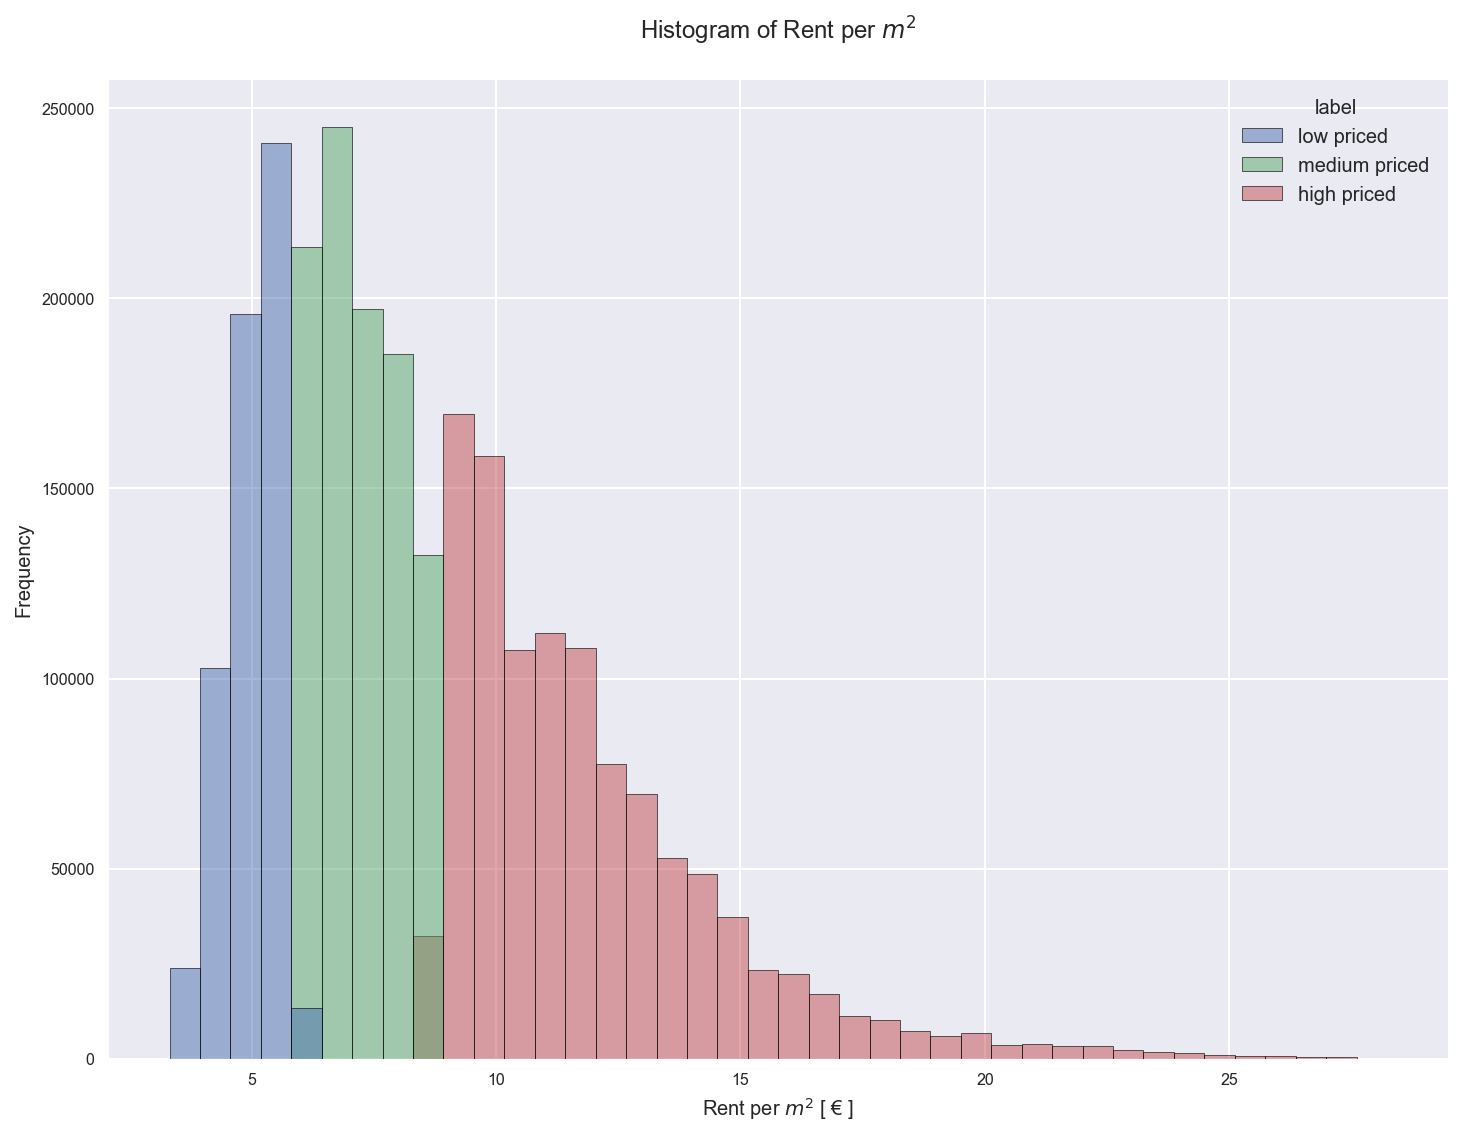

In [58]:
sns.histplot(data=df, x='rent_sqm', hue='label', bins=40, hue_order=label_order)
plt.title('Histogram of Rent per $m^2$')
plt.xlabel('Rent per $m^2$ [ € ]')
plt.ylabel('Frequency')

### Start with Data Analysis

In [46]:
# Create some Aggregations
city_count = df.groupby(['City', 'year']).label.value_counts(normalize=True).reset_index(name='label_ratio')
wohnflaeche = df.groupby(['City', 'year', 'label']).wohnflaeche.mean().reset_index(name='wohnflaeche_mean')
baujahr = df.groupby(['City', 'year', 'label']).baujahr.mean().reset_index(name='baujahr_mean')
rent_sqm = df.groupby(['City', 'year', 'label']).rent_sqm.mean().reset_index(name='rent_sqm_mean')
miete_mean = df.groupby(['City', 'year', 'label']).mietekalt.mean().reset_index(name='mietekalt_mean')
laufzeittage = df.groupby(['City', 'year', 'label']).laufzeittage.mean().reset_index(name='laufzeittage_mean')
anzahletagen = df.groupby(['City', 'year', 'label']).anzahletagen.mean().reset_index(name='anzahletagen_mean')
zimmeranzahl = df.groupby(['City', 'year', 'label']).zimmeranzahl.mean().reset_index(name='zimmeranzahl_mean')
schlafzimmer = df.groupby(['City', 'year', 'label']).schlafzimmer.mean().reset_index(name='schlafzimmer_mean')


summary =miete_mean.merge(wohnflaeche, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label']) \
.merge(baujahr, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label']) \
.merge(rent_sqm, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label']) \
.merge(laufzeittage, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label']) \
.merge(anzahletagen, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label']) \
.merge(zimmeranzahl, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label']) \
.merge(schlafzimmer, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label']) \
.merge(city_count, left_on=['City', 'year', 'label'], right_on=['City', 'year', 'label'])







In [47]:
city_count = df.groupby(['City', 'year', 'ausstattung']).label.value_counts(normalize=True).reset_index(name='label_ratio')
wohnflaeche = df.groupby(['City', 'year', 'label', 'ausstattung']).wohnflaeche.mean().reset_index(name='wohnflaeche_mean')
baujahr = df.groupby(['City', 'year', 'label', 'ausstattung']).baujahr.mean().reset_index(name='baujahr_mean')
rent_sqm = df.groupby(['City', 'year', 'label', 'ausstattung']).rent_sqm.mean().reset_index(name='rent_sqm_mean')
miete_mean = df.groupby(['City', 'year', 'label', 'ausstattung']).mietekalt.mean().reset_index(name='mietekalt_mean')
laufzeittage = df.groupby(['City', 'year', 'label', 'ausstattung']).laufzeittage.mean().reset_index(name='laufzeittage_mean')
anzahletagen = df.groupby(['City', 'year', 'label', 'ausstattung']).anzahletagen.mean().reset_index(name='anzahletagen_mean')
zimmeranzahl = df.groupby(['City', 'year', 'label', 'ausstattung']).zimmeranzahl.mean().reset_index(name='zimmeranzahl_mean')
schlafzimmer = df.groupby(['City', 'year', 'label', 'ausstattung']).schlafzimmer.mean().reset_index(name='schlafzimmer_mean')


summary_ausstatung =miete_mean.merge(wohnflaeche, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung']) \
.merge(baujahr, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung']) \
.merge(rent_sqm, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung']) \
.merge(laufzeittage, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung']) \
.merge(anzahletagen, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung']) \
.merge(zimmeranzahl, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung']) \
.merge(schlafzimmer, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung']) \
.merge(city_count, left_on=['City', 'year', 'label', 'ausstattung'], right_on=['City', 'year', 'label', 'ausstattung'])







### Part 3 Change over time


#### Change of cluster rent sqm mean over time

In [92]:
# Create Aggregation year and label rent_sqm mean 
rent_sqm_mean = df.groupby(['year', 'label']).rent_sqm.mean().reset_index(name='rent_sqm_mean')
rent_sqm_mean.head()

,year,label,rent_sqm_mean
0,2007,high priced,10.301518
1,2007,low priced,4.912854
2,2007,medium priced,7.111809
3,2008,high priced,10.475461
4,2008,low priced,4.953686


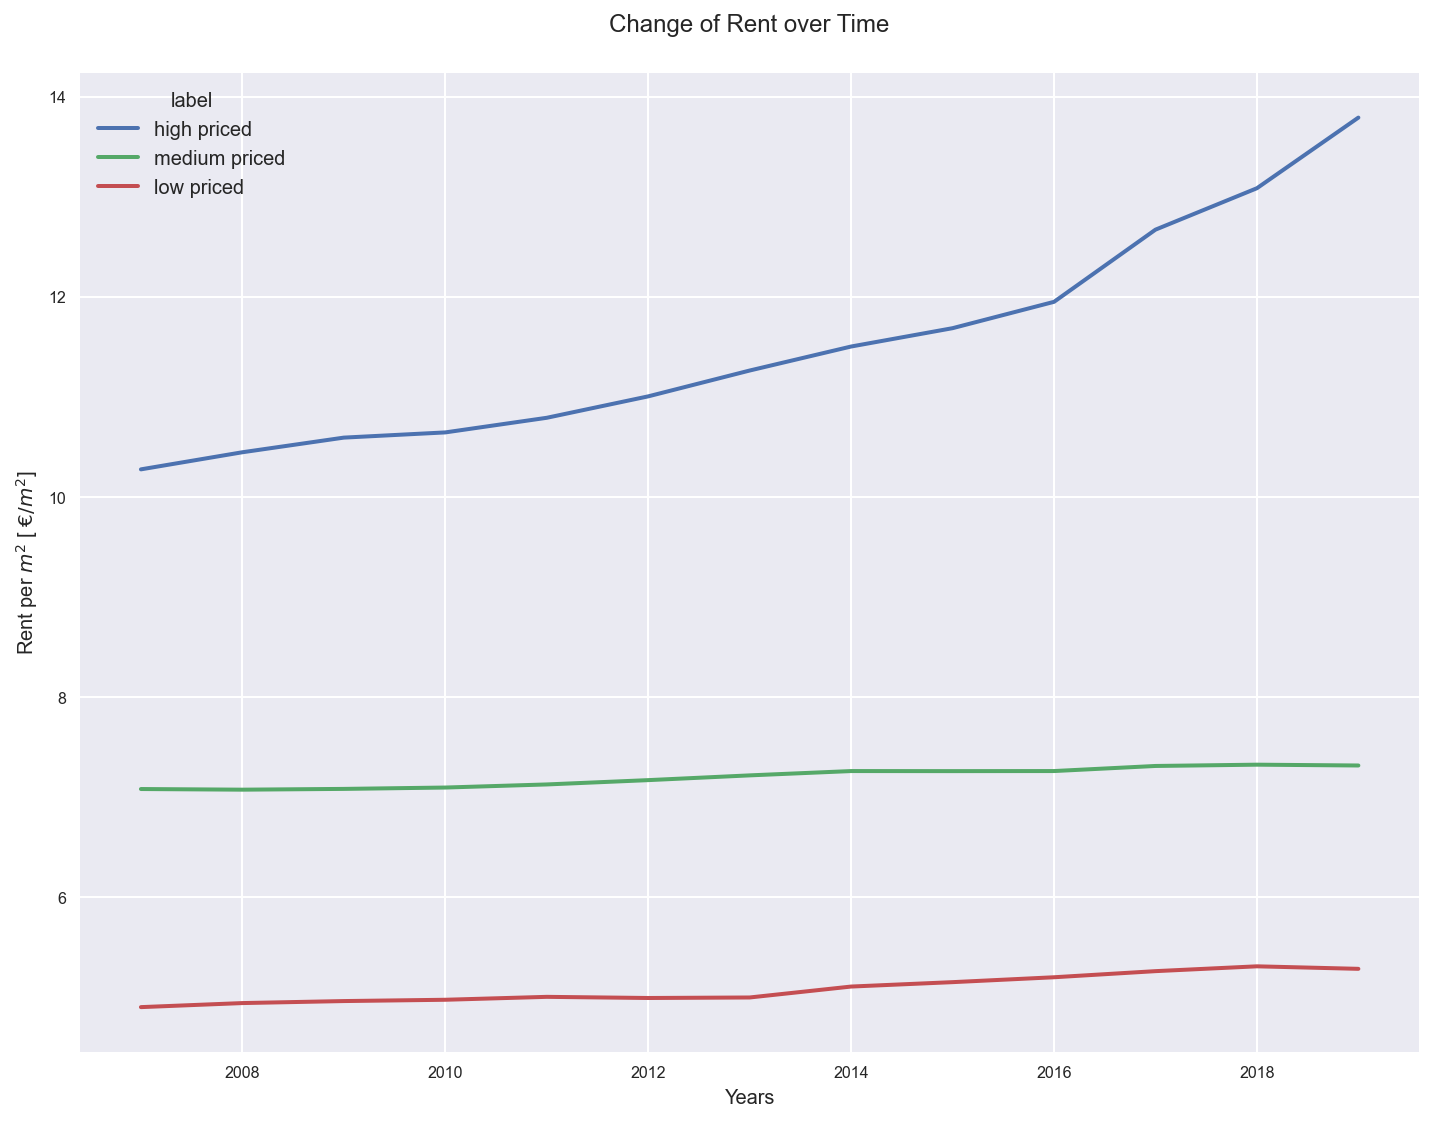

In [62]:
sns.lineplot(data=rent_sqm_mean, x='year', y='rent_sqm_mean', hue='label', hue_order=label_order[::-1])
plt.title('Change of Rent over Time')
plt.xlabel('Years')
plt.ylabel('Rent per $m^2$ [ $€/m^2$]');

#### Cluster Größe über die Zeit

In [63]:
label_count_time = df.groupby(['year']).label.value_counts(normalize=True).reset_index(name='label_count')
label_count_time.head()

,year,label,label_count
0,2007,low priced,0.417852
1,2007,medium priced,0.380771
2,2007,high priced,0.201378
3,2008,low priced,0.394097
4,2008,medium priced,0.388095


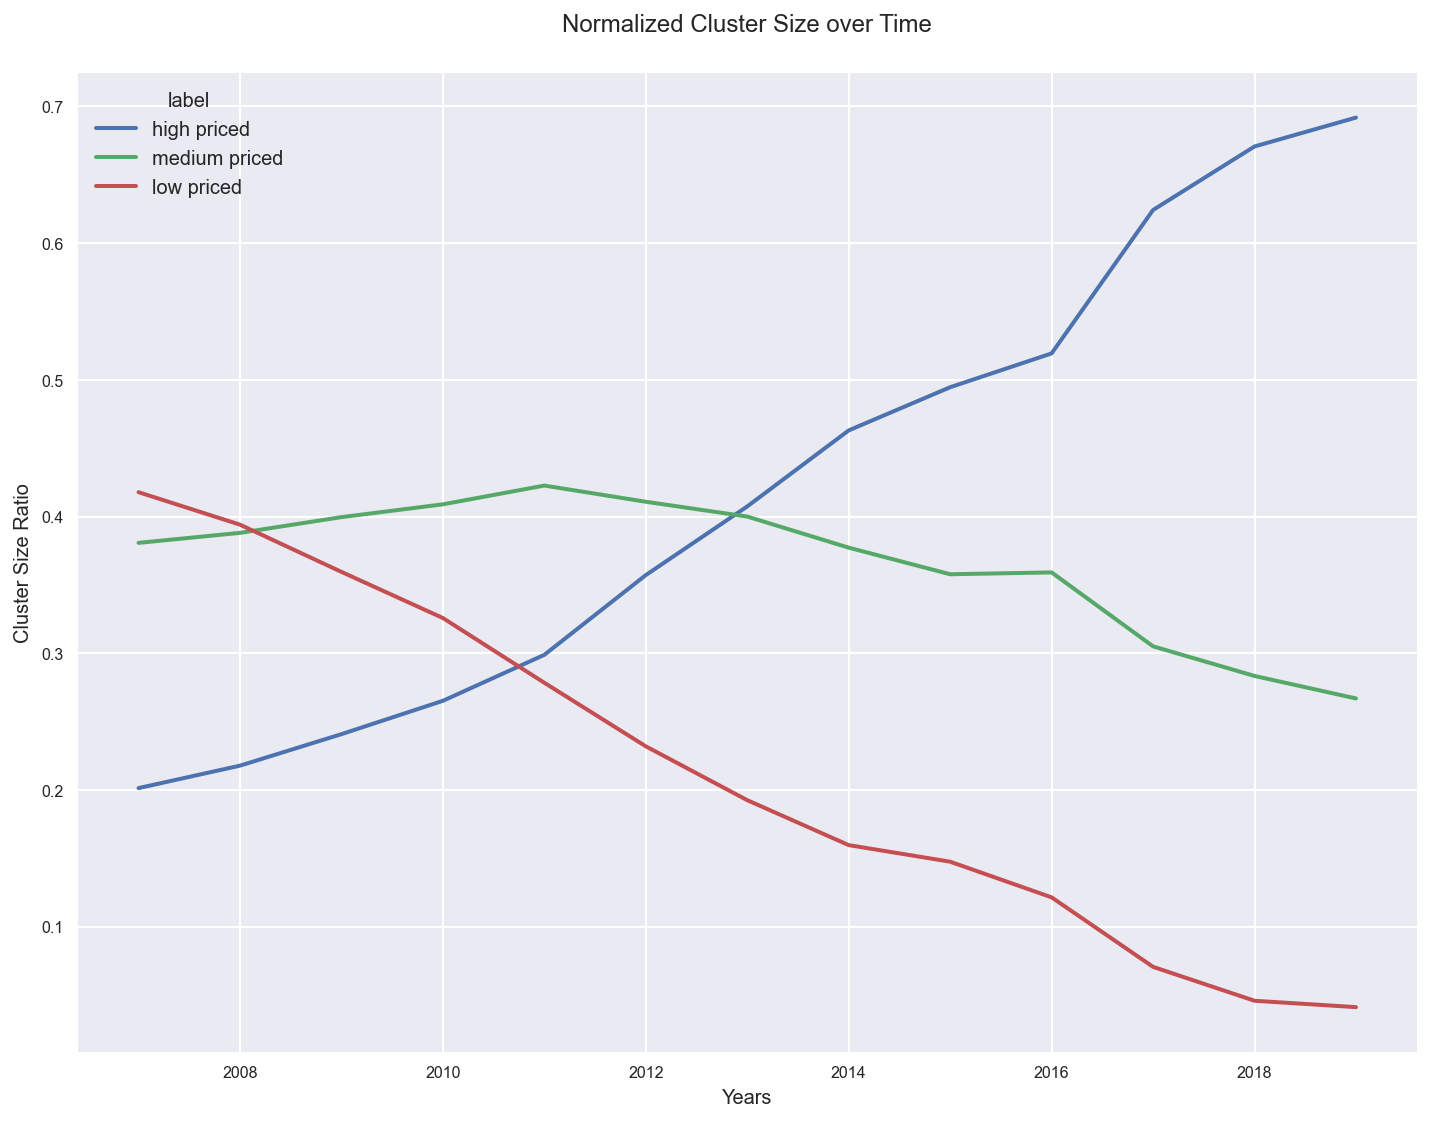

In [64]:
sns.lineplot(data=label_count_time, x='year', y='label_count', hue='label', hue_order=label_order[::-1])
plt.title('Normalized Cluster Size over Time')
plt.xlabel('Years')
plt.ylabel('Cluster Size Ratio');

####  Wie ist die Umverteilung in den Städten?


In [93]:
label_count_city = df.groupby(['City', 'year']).label.value_counts(normalize=True).reset_index(name='label_count')
label_count_city = label_count_city.query('year == 2007 or year == 2019')

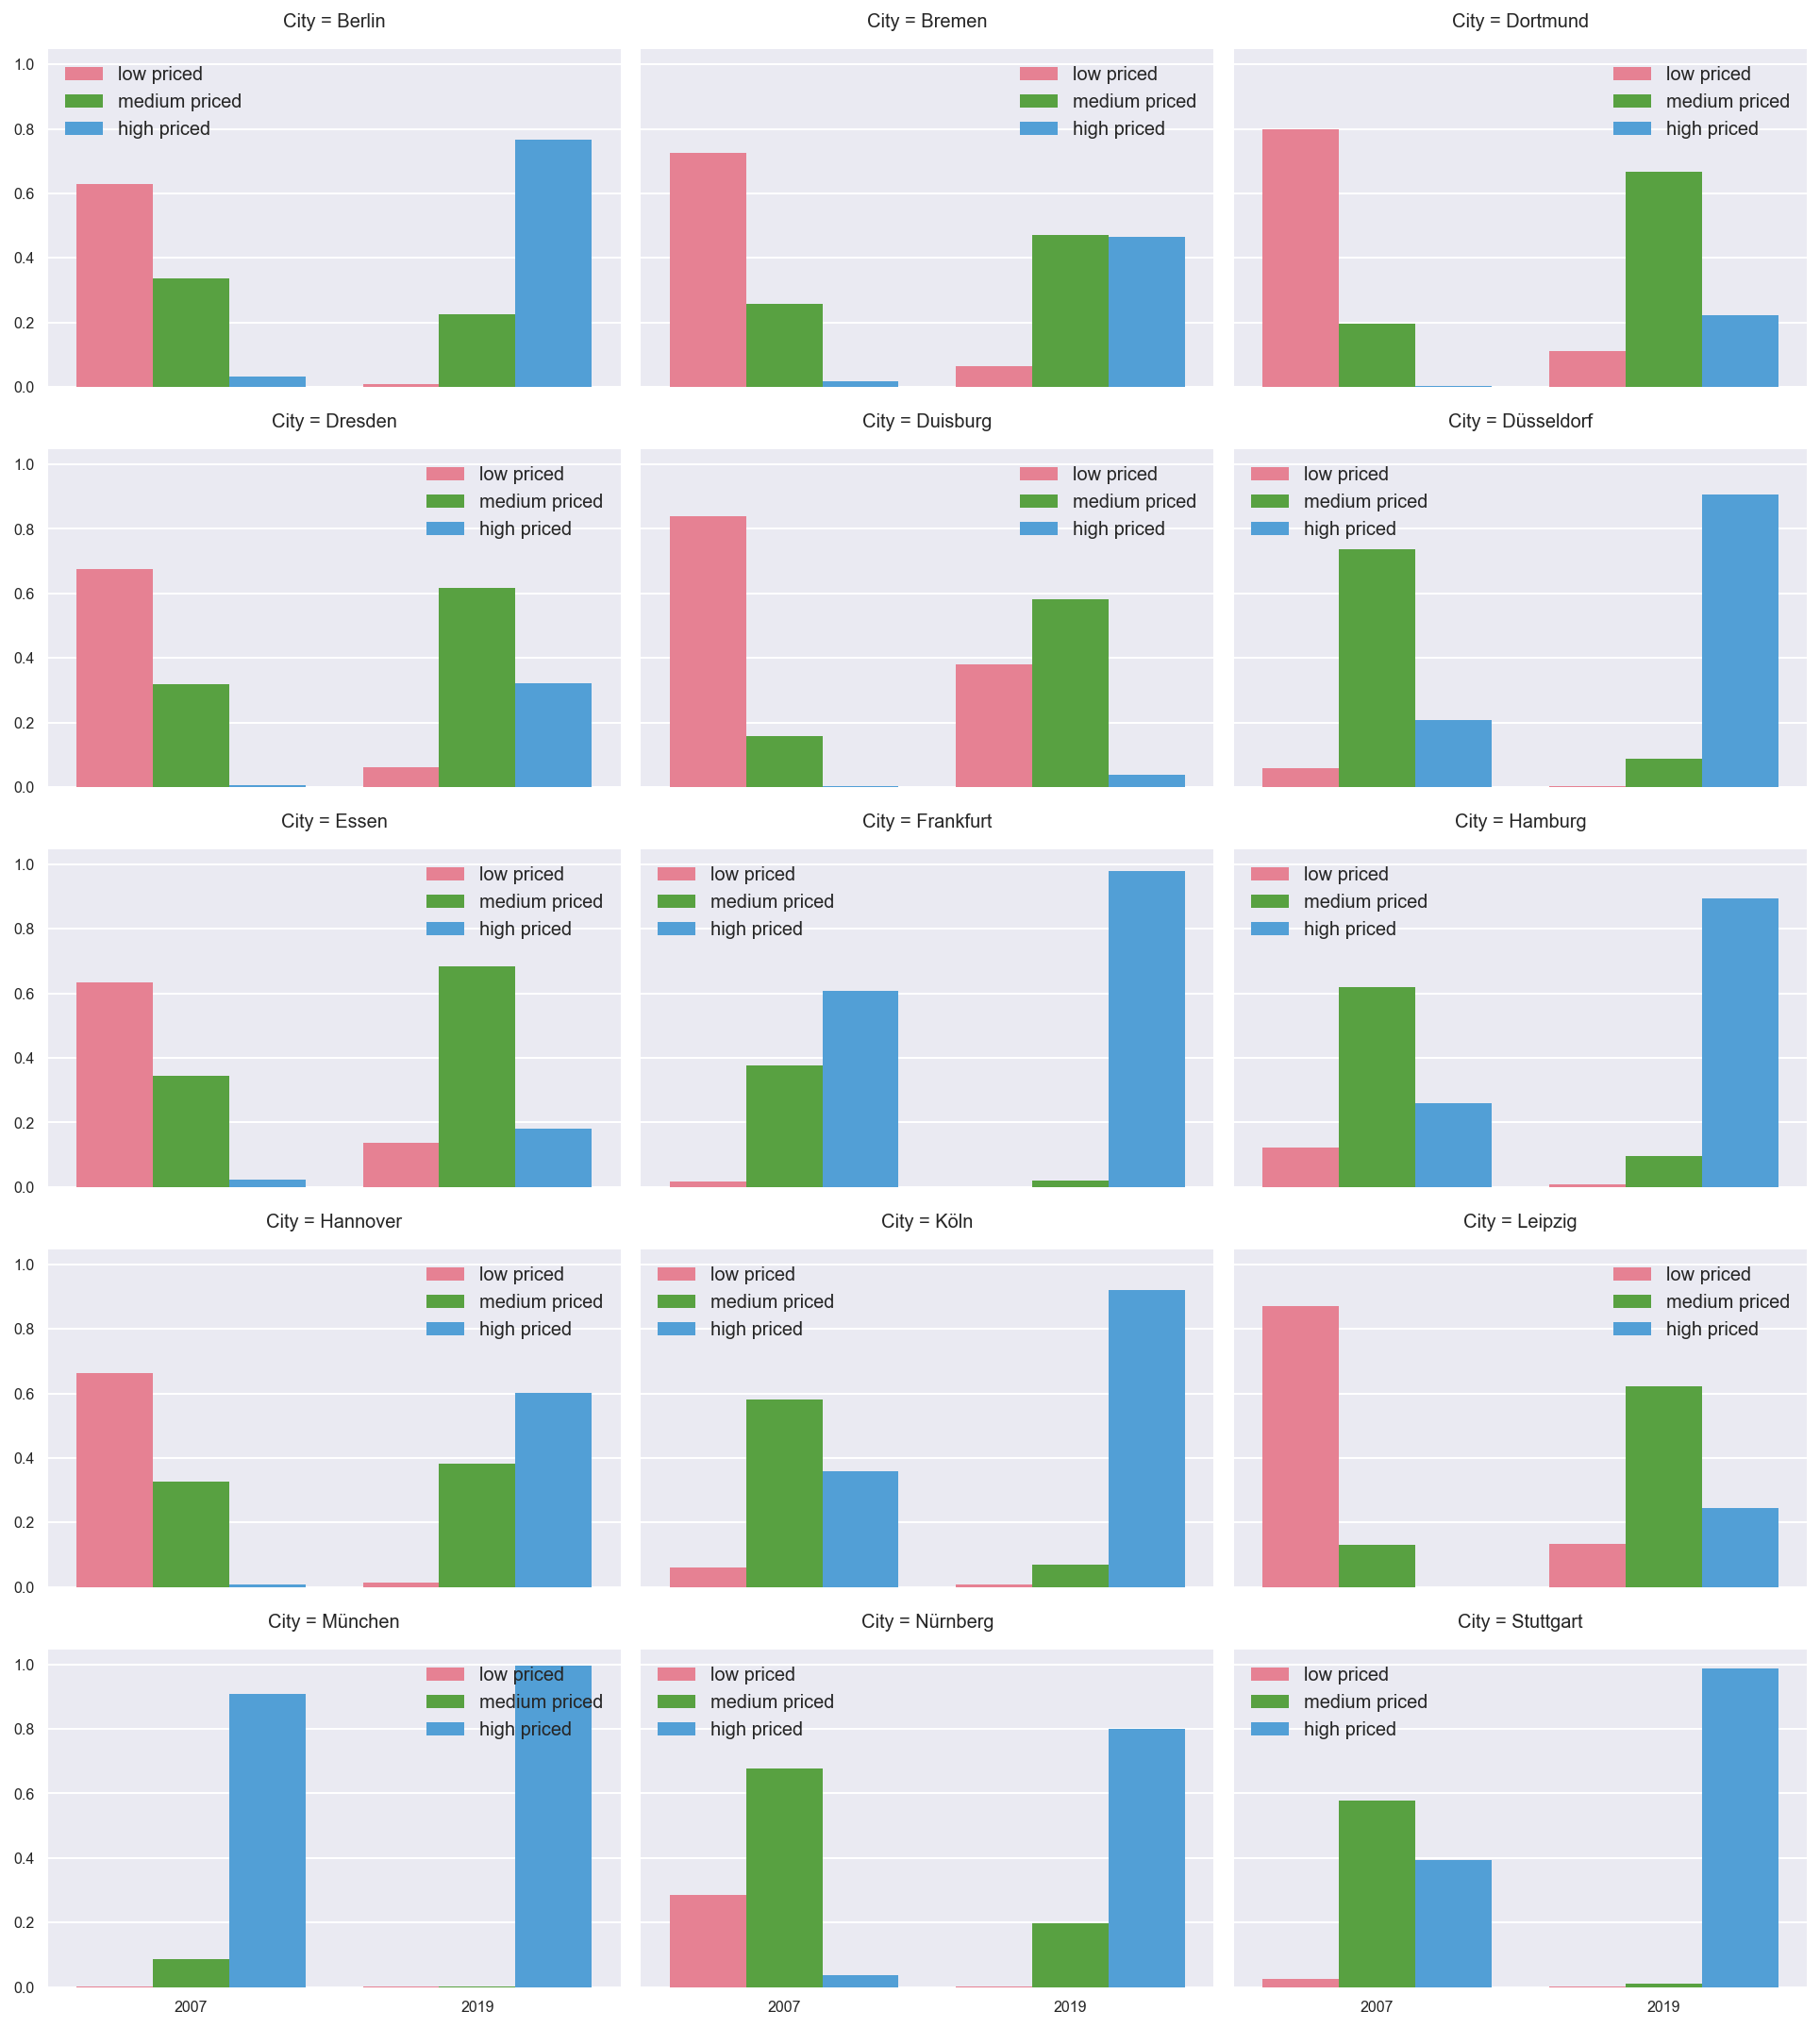

In [94]:

g = sns.FacetGrid(data=label_count_city, col='City', col_wrap=3, height=3, aspect=1.5)
g.map_dataframe(sns.barplot, x='year', y='label_count', hue='label', hue_order=label_order, palette='husl')

for ax in g.axes.ravel():
    ax.legend()

### Changes in rent per sqm 

### Mean Rent Increase over time and City

In [95]:
mean_rent_sqm_city = df.groupby(['City', 'year']).rent_sqm.mean().reset_index(name='rent_sqm_mean')
mean_rent_sqm_city = mean_rent_sqm_city.pivot(index='City', columns='year', values='rent_sqm_mean')



In [96]:
mean_rent_sqm_city[2019] / mean_rent_sqm_city[2007] * 100 - 100

City
Berlin        111.792455
Bremen         63.129775
Dortmund       49.099668
Dresden        51.344299
Duisburg       24.862916
Düsseldorf     51.287213
Essen          30.840389
Frankfurt      65.262332
Hamburg        64.344993
Hannover       70.353852
Köln           51.779747
Leipzig        57.507064
München        79.062079
Nürnberg       76.758146
Stuttgart      94.172299
dtype: float64

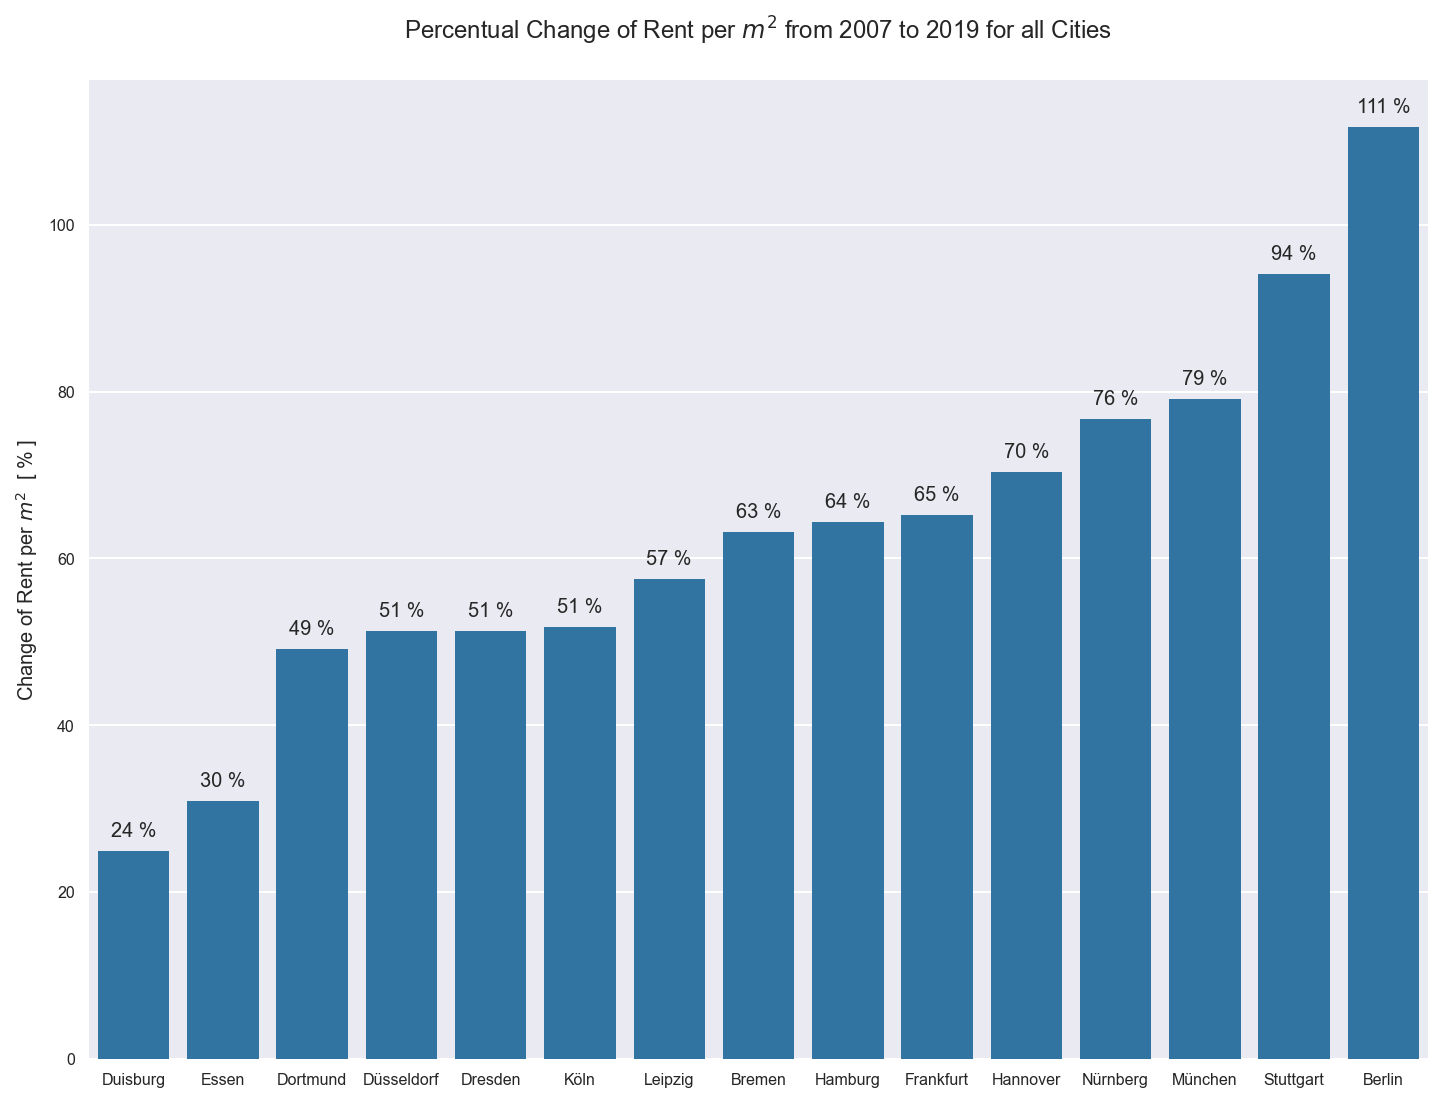

In [97]:
change_df = summary_loss.pivot(index='City', columns='year', values='rent_sqm_mean')
change_df = (change_df[2019] / change_df[2007] * 100 - 100).reset_index(name='change_rent_sqm_mean').sort_values(by='change_rent_sqm_mean', ascending=True)


ax = sns.barplot(data=change_df, x='City', y='change_rent_sqm_mean', color=blue)
plt.title('Percentual Change of Rent per $m^2$ from 2007 to 2019 for all Cities')
plt.xlabel(None)
plt.ylabel('Change of Rent per $m^2$  [ % ]')

for p in ax.patches:
    text = '{} %'.format(int(p.get_height()))
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



In [98]:
years = [2007, 2019]
summary_rent_2007 = df.query('year == 2007').groupby(['City']).rent_sqm.mean().reset_index(name='rent_sqm_mean').sort_values(by='rent_sqm_mean')
summary_rent_2019 = df.query('year == 2019').groupby(['City']).rent_sqm.mean().reset_index(name='rent_sqm_mean').sort_values(by='rent_sqm_mean')

summary_rent_2019['year'] = 2019
summary_rent_2007['year'] = 2007


summary_rent = pd.concat([summary_rent_2019, summary_rent_2007])

In [100]:
summary_rent.head()

,City,rent_sqm_mean,year
4,Duisburg,6.294618,2019
6,Essen,7.500048,2019
2,Dortmund,7.725058,2019
11,Leipzig,7.768760,2019
3,Dresden,8.424403,2019


In [103]:
summary_rent_2007_pivot = summary_rent_2007.pivot(index='City', columns='year', values='rent_sqm_mean')

    

#### Add some columns for calculated differences 

In [104]:
series = summary_rent_2007_pivot[2007]
for i in range(2007,2019,1):
    series = pd.Series(series*1.02, name=i+1)
    summary_rent_2007_pivot = summary_rent_2007_pivot.join(series)



In [105]:
inflation_2019 = pd.DataFrame(summary_rent_2007_pivot[2019]).reset_index()
inflation_2019['year'] = '2019_2%'
inflation_2019.columns=['City', 'rent_sqm_mean', 'year']
inflation_2019
summary_rent = summary_rent.append(inflation_2019)

In [106]:
summary_rent_pivot = summary_rent.pivot(index='City', columns='year', values='rent_sqm_mean')
summary_rent_pivot['2019 - 2007'] = summary_rent_pivot[2019] - summary_rent_pivot[2007]
summary_rent_pivot['2019_2% - 2007'] = summary_rent_pivot['2019_2%'] - summary_rent_pivot[2007]
summary_rent_pivot['Diff'] = summary_rent_pivot['2019 - 2007'] - summary_rent_pivot['2019_2% - 2007']
summary_rent_pivot = summary_rent_pivot.sort_values(by='Diff')
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')
summary_rent_pivot

year,2007,2019,2019_2%,2019 - 2007,2019_2% - 2007,Diff
City,,,,,,
Duisburg,5.041223,6.294618,6.393490,1.253395,1.352267,-0.098872
Essen,5.732211,7.500048,7.269830,1.767836,1.537619,0.230218
Dortmund,5.181137,7.725058,6.570935,2.543921,1.389798,1.154124
Dresden,5.566383,8.424403,7.059519,2.858020,1.493136,1.364884
Leipzig,4.932325,7.768760,6.255381,2.836435,1.323056,1.513380
Düsseldorf,7.748003,11.721738,9.826342,3.973735,2.078338,1.895397
Bremen,5.417372,8.837348,6.870538,3.419975,1.453166,1.966809
Köln,8.232465,12.495215,10.440756,4.262750,2.208291,2.054458
Hannover,5.665774,9.651864,7.185571,3.986090,1.519797,2.466293


#### Difference between 2007 and 2019

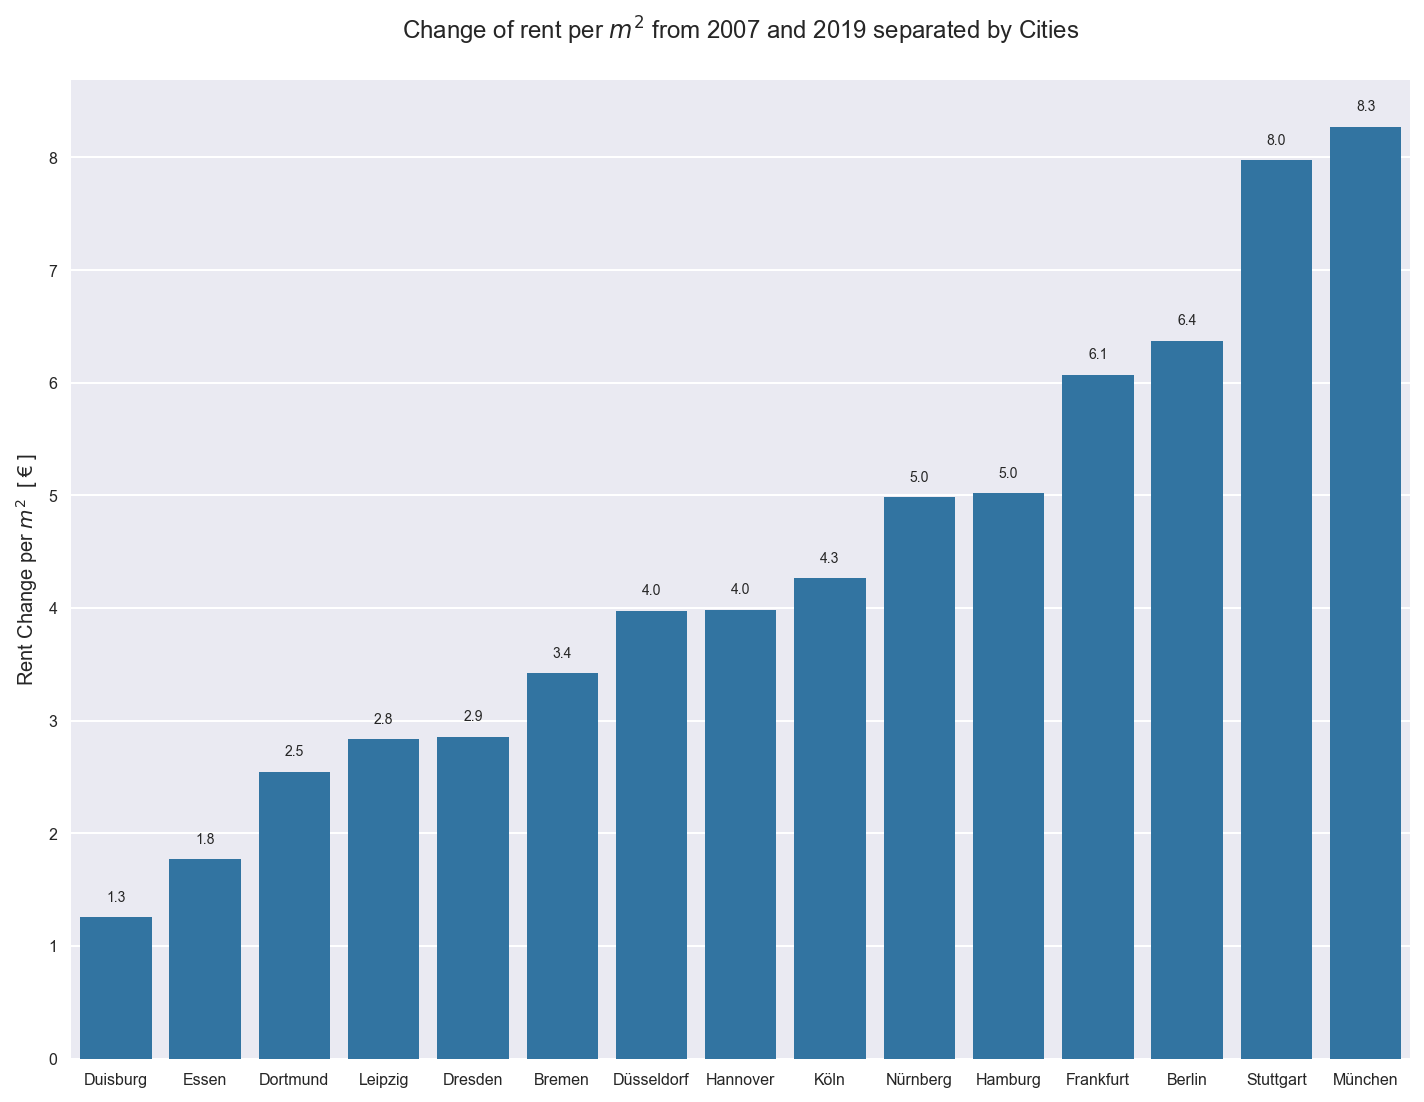

In [107]:
summary_rent_pivot = summary_rent_pivot.sort_values(by='2019 - 2007')
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended.query('year=="2019 - 2007"'), x='City', y='value', color=blue)
plt.title('Change of rent per $m^2$ from 2007 and 2019 separated by Cities')

plt.ylabel('Rent Change per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)



#### Difference between 2019 and 2019 in case of 2% inflation

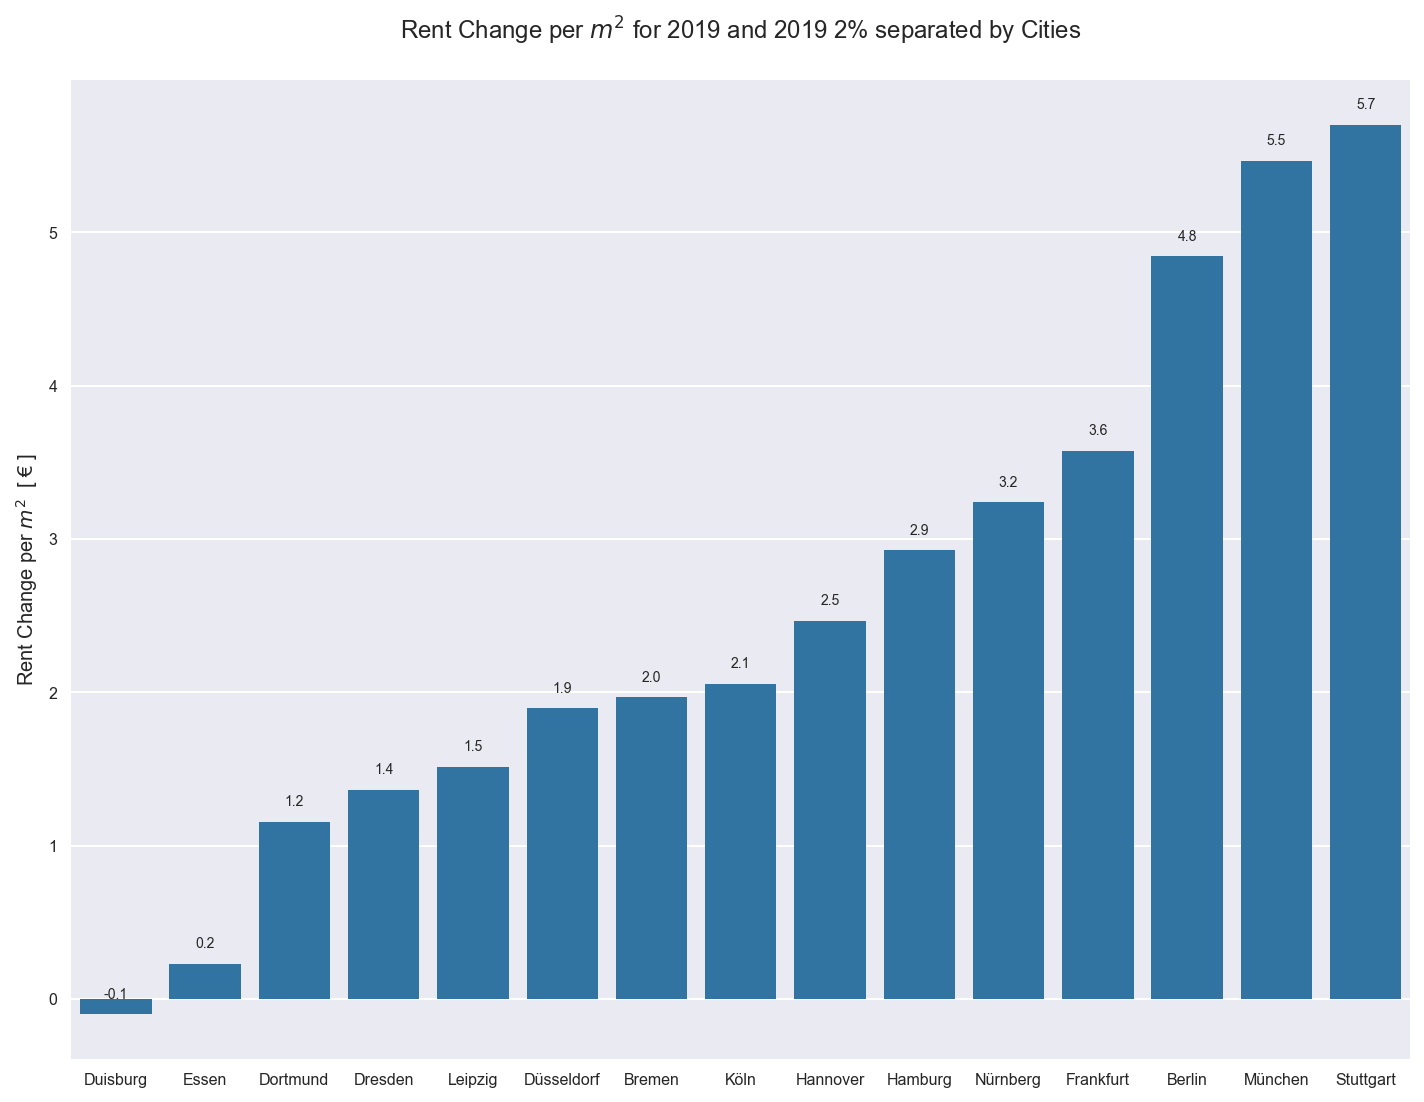

In [202]:
summary_rent_pivot = summary_rent_pivot.sort_values(by='Diff')
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended.query('year=="Diff"'), x='City', y='value', color=blue)
plt.title('Rent Change per $m^2$ for 2019 and 2019 2% separated by Cities')
plt.ylabel('Rent Change per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)



#### Difference 2007 to 2019 under 2% inflation assumption

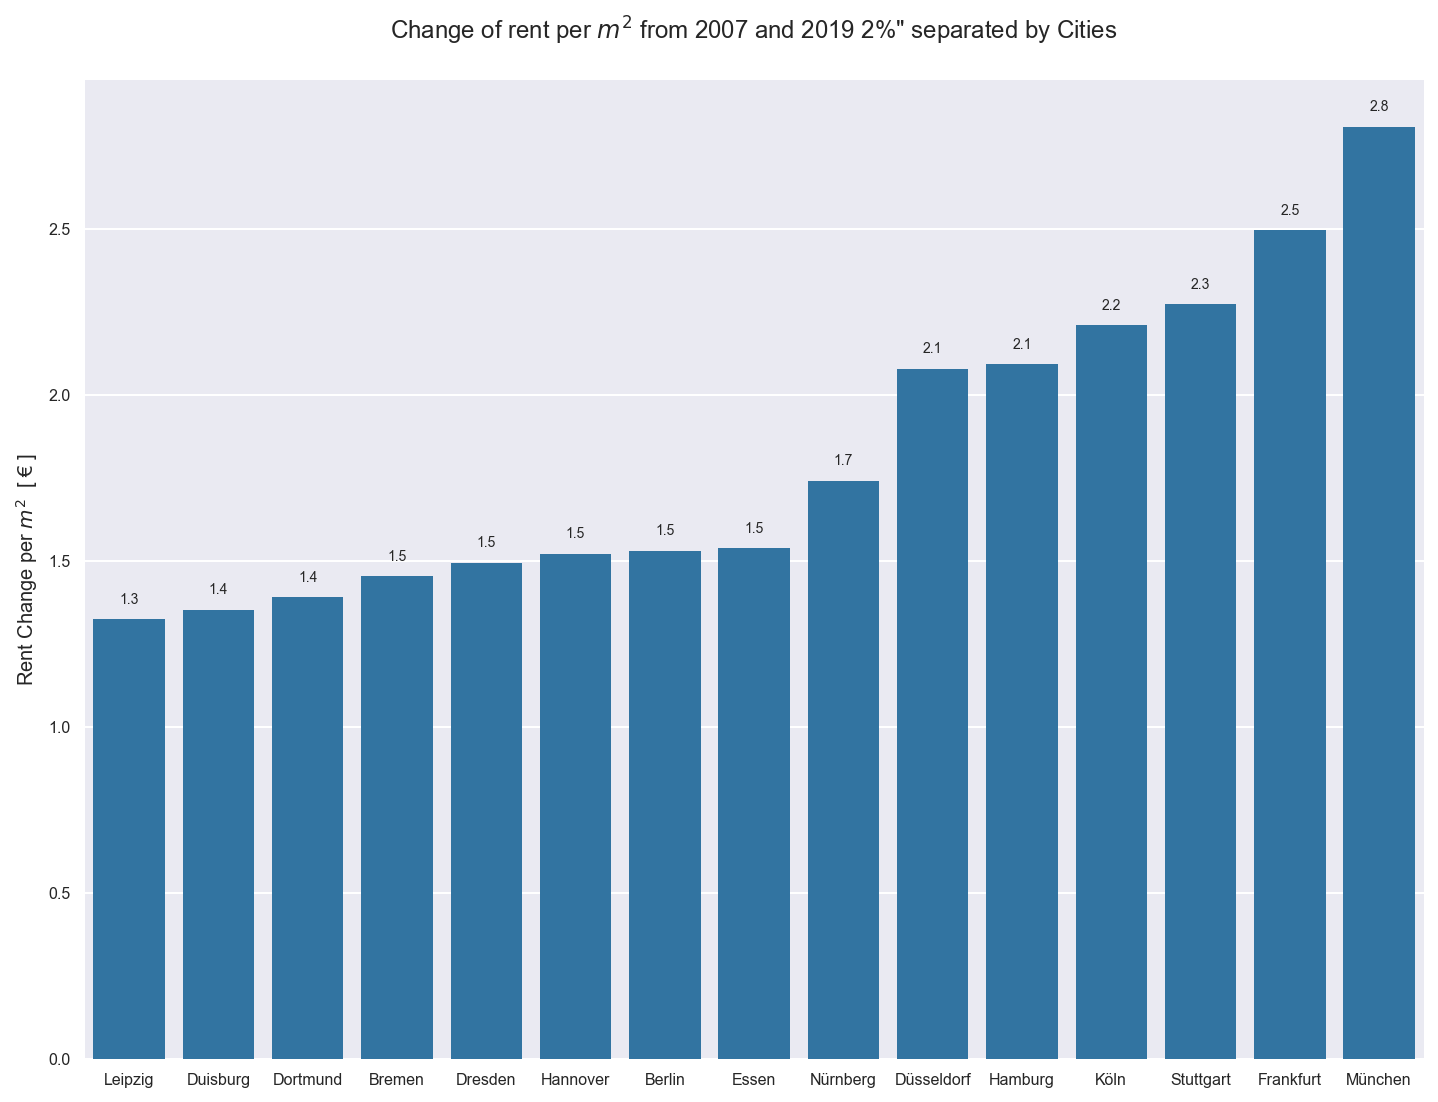

In [199]:
summary_rent_pivot = summary_rent_pivot.sort_values(by='2019_2% - 2007')
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended.query('year=="2019_2% - 2007"'), x='City', y='value', color=blue)
plt.title('Change of rent per $m^2$ from 2007 and 2019 2%" separated by Cities')

plt.ylabel('Rent Change per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)



In [108]:
ranking_2007 = summary_rent_2007.City.values
ranking_2019 = summary_rent_2019.City.values

change_ranking = pd.DataFrame()
idx=[]
change=[]

for i, city in enumerate(ranking_2019):
    idx.append(city)
    change.append(list(ranking_2007).index(city) - i)

change_ranking=pd.DataFrame(idx, change).reset_index().sort_values(by='index')
    
change_ranking.columns = ['change', 'City']


Text(0.5, 0, 'Change in City Ranking')

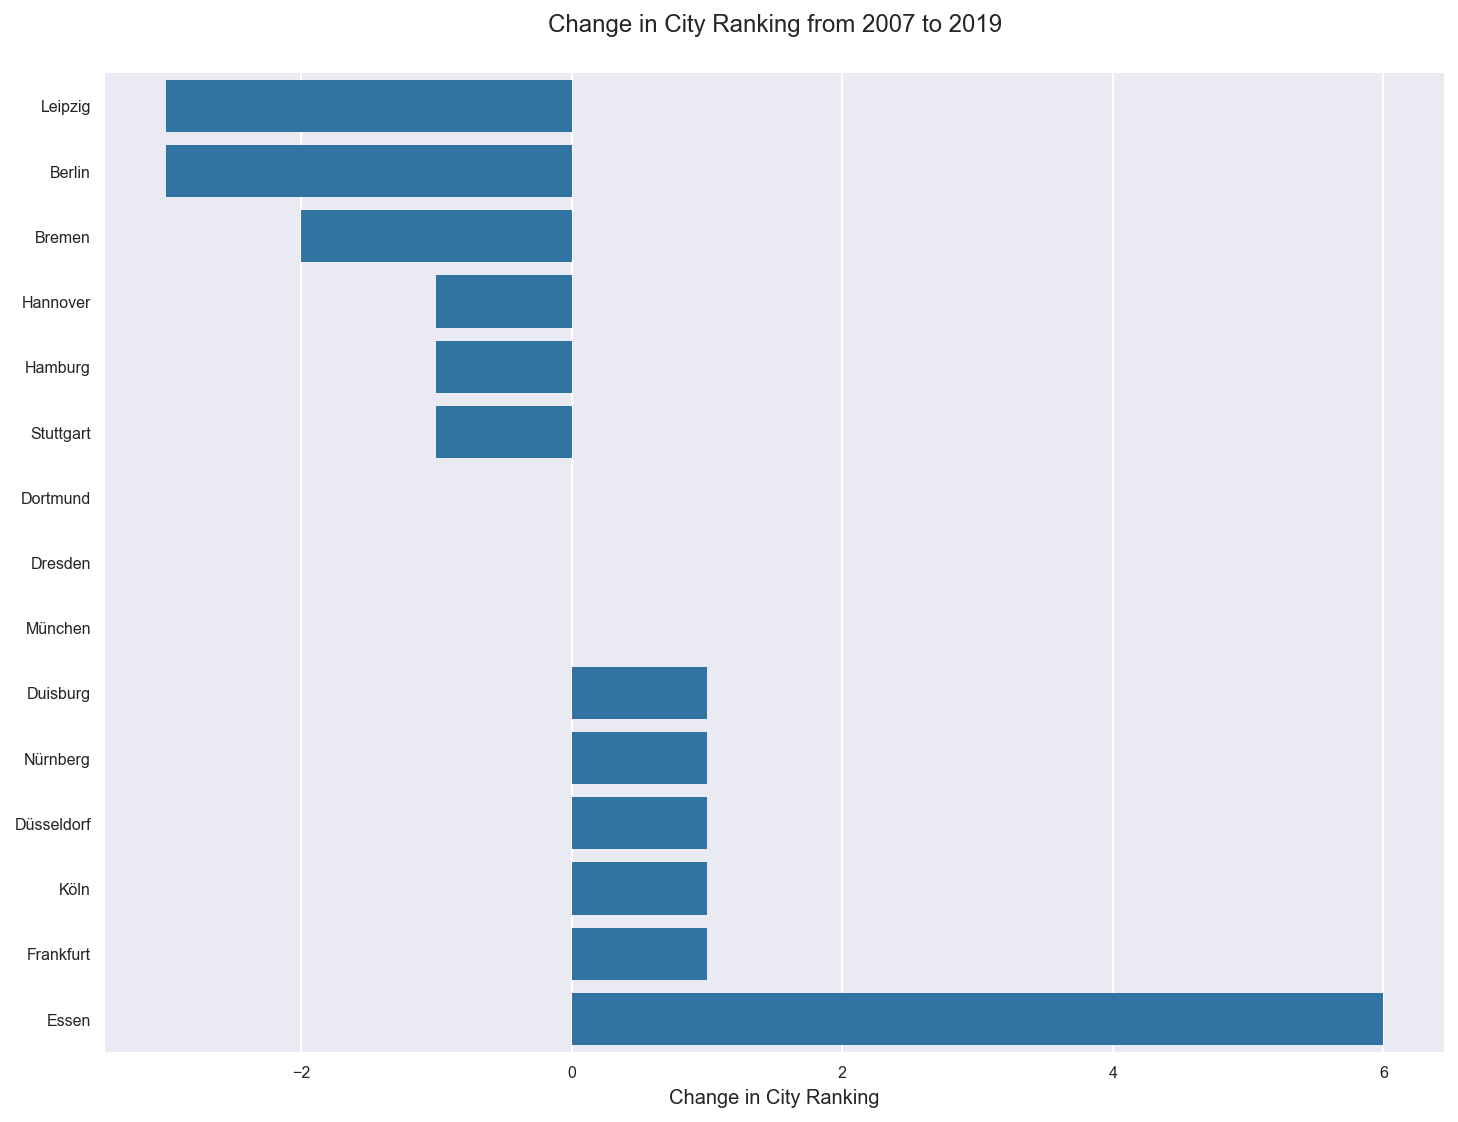

In [109]:
sns.barplot(data=change_ranking, y='City', x='change', color=blue)
plt.title('Change in City Ranking from 2007 to 2019')
plt.ylabel(None)
plt.xlabel('Change in City Ranking')

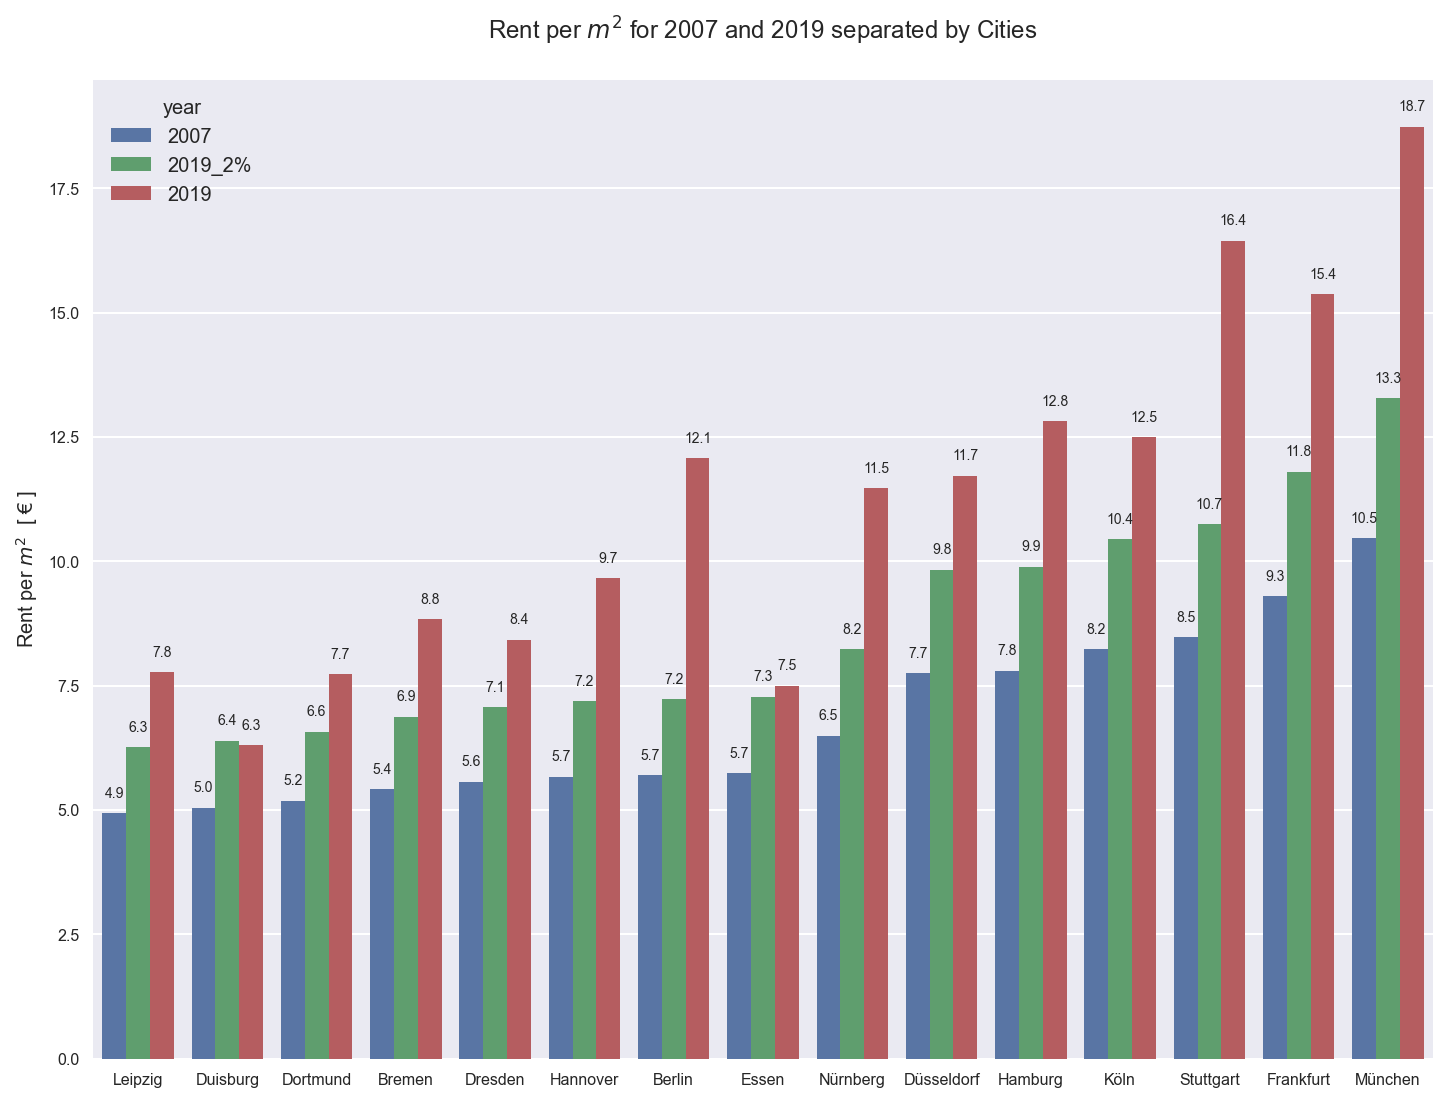

In [110]:
summary_rent_pivot = summary_rent_pivot.sort_values(by=2007)
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended, x='City', y='value', hue='year', hue_order=[2007, '2019_2%', 2019])
plt.title('Rent per $m^2$ for 2007 and 2019 separated by Cities')
plt.ylabel('Rent per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)



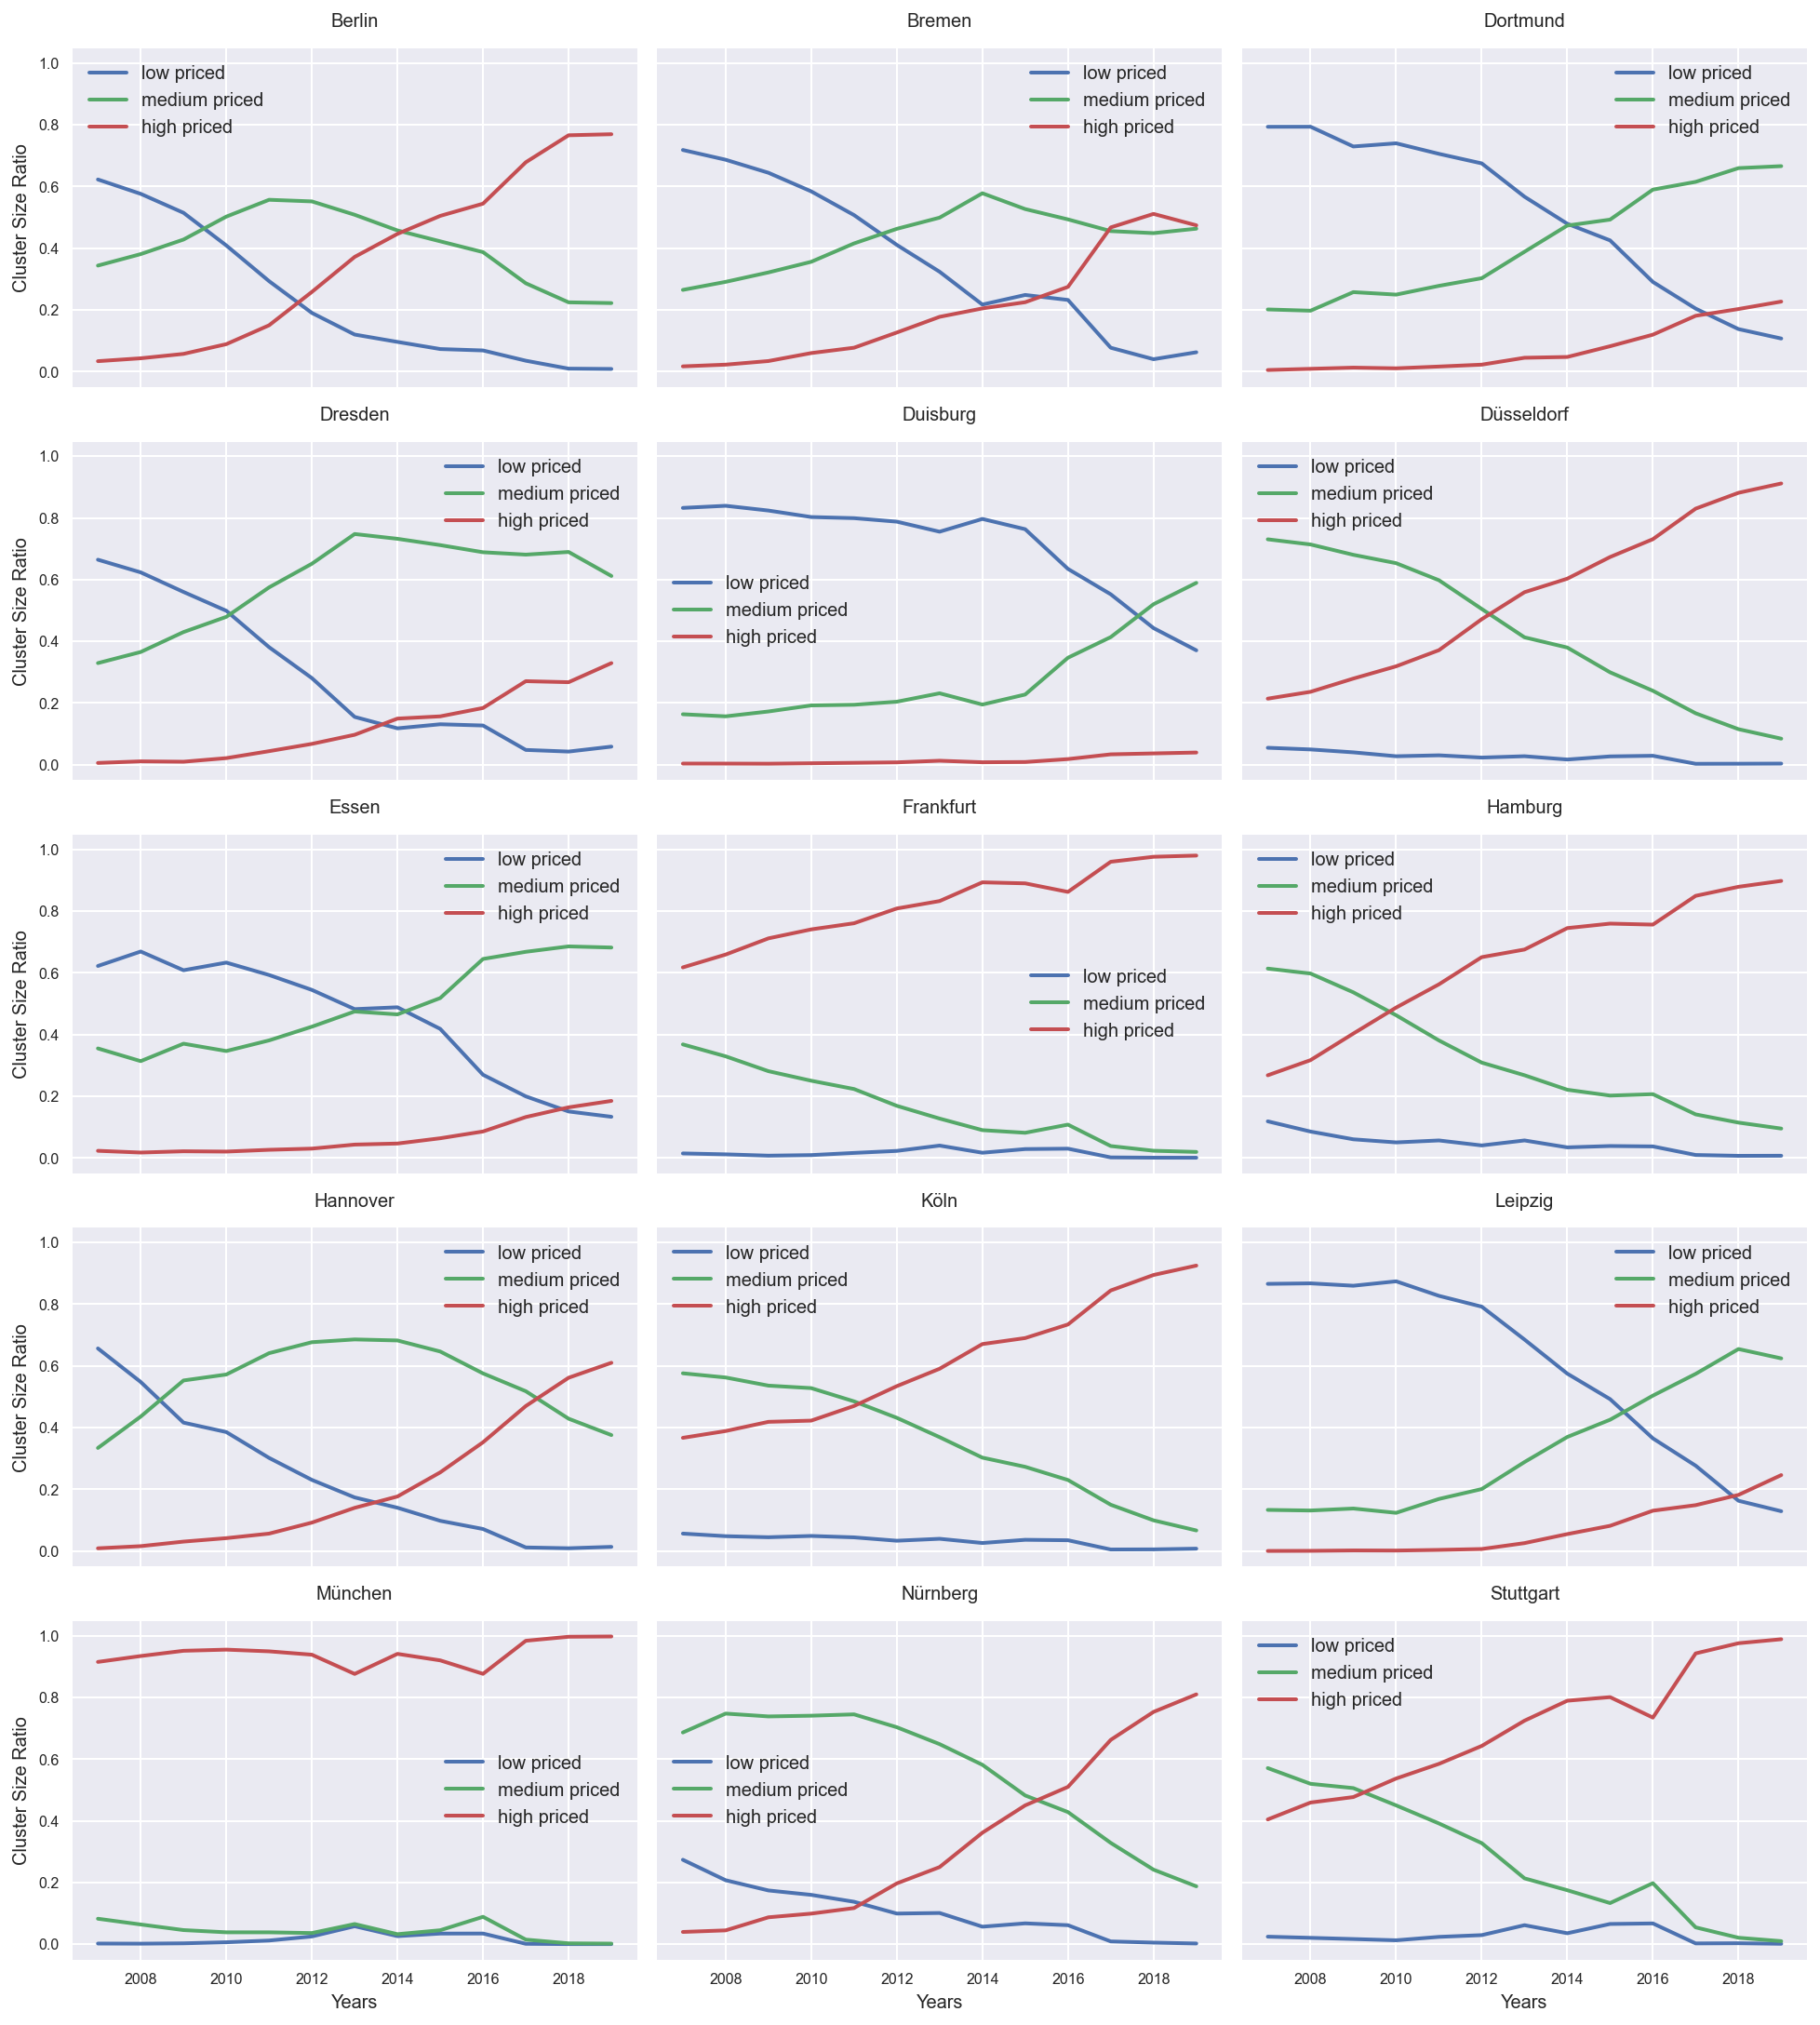

In [128]:
g = sns.FacetGrid(data=cluster_count, col='City', col_wrap=3, height=3, aspect=1.5, sharey=True)

g.map_dataframe(sns.lineplot, x='year', y='count', hue='label', hue_order=label_order)
g.set_axis_labels(x_var='Years', y_var='Cluster Size Ratio')
g.set_titles('{col_name}')

for ax in g.axes.ravel():
    ax.legend()


#plt.title('Change of Cluster Size over Time')
#plt.xlabel('Years')

#plt.ylabel('Cluster Size Ratio');

In [ ]:
df.to_pickle('data/rent_clustering_done.pkl')